In [1]:
!pip install seaborn

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from sklearn import linear_model, svm, discriminant_analysis, metrics
from scipy import optimize
import seaborn as sns

In [2]:

colors = ['blue','red']
cmap = pltcolors.ListedColormap(colors)
nFeatures = 2
N = 100
def plotHeatMap(X, classes, title=None, fmt='.2g', ax=None, xlabel=None, ylabel=None):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, \
                     fmt=fmt, cmap=plt.cm.Blues, ax=ax) #notation: "annot" not "annote"
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)

def plotConfusionMatrix(yTrue, yEst, classes, title=None, fmt='.2g', ax=None):
    plotHeatMap(metrics.confusion_matrix(yTrue, yEst), classes, title, fmt, ax, xlabel='Estimations', \
                ylabel='True values');


def generateBatchXor(n, mu=0.5, sigma=0.5, seed=None):
    """
    Generate n samples in a XOR pattern using Gaussian distributions.

    Parameters:
    - n: number of samples
    - mu: mean of the Gaussian distribution
    - sigma: standard deviation of the Gaussian distribution
    - seed: seed for the random number generators (default: None)

    Returns:
    - X: generated features
    - y: generated labels
    """
    if seed is not None:
        np.random.seed(seed)

    X = np.random.normal(mu, sigma, (n, 2))
    yB0 = np.random.uniform(0, 1, n) > 0.5
    yB1 = np.random.uniform(0, 1, n) > 0.5

    y = np.logical_xor(yB0, yB1).astype(int)

    y0 = 2. * yB0 - 1
    y1 = 2. * yB1 - 1
    X[:, 0] *= y0
    X[:, 1] *= y1
    X -= X.mean(axis=0)

    return X, y


seed = 42


def plotLine(ax, xRange, w, x0, label, color='grey', linestyle='-', alpha=1.):
    """ Plot a (separating) line given the normal vector (weights) and point of intercept """
    if type(x0) == int or type(x0) == float or type(x0) == np.float64:
        x0 = [0, -x0 / w[1]]
    yy = -(w[0] / w[1]) * (xRange - x0[0]) + x0[1]
    ax.plot(xRange, yy, color=color, label=label, linestyle=linestyle)

def plotSvm(X, y, support=None, w=None, intercept=0., label='Data', separatorLabel='Separator',
            ax=None, bound=[[-1., 1.], [-1., 1.]]):
    """ Plot the SVM separation, and margin """
    if ax is None:
        fig, ax = plt.subplots(1)

    im = ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, alpha=0.5, label=label)
    if support is not None:
        ax.scatter(support[:,0], support[:,1], label='Support', s=80, facecolors='none',
                   edgecolors='y', color='y')
        print("Number of support vectors = %d" % (len(support)))
    if w is not None:
        xx = np.array(bound[0])
        plotLine(ax, xx, w, intercept, separatorLabel)
        # Plot margin
        if support is not None:
            signedDist = np.matmul(support, w)
            margin = np.max(signedDist) - np.min(signedDist) * np.sqrt(np.dot(w, w))
            supportMaxNeg = support[np.argmin(signedDist)]
            plotLine(ax, xx, w, supportMaxNeg, 'Margin -', linestyle='-.', alpha=0.8)
            supportMaxPos = support[np.argmax(signedDist)]
            plotLine(ax, xx, w, supportMaxPos, 'Margin +', linestyle='--', alpha=0.8)
            ax.set_title('Margin = %.3f' % (margin))
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlim(bound[0])
    ax.set_ylim(bound[1])
    cb = plt.colorbar(im, ax=ax)
    loc = np.arange(-1,1,1)
    cb.set_ticks(loc)
    cb.set_ticklabels(['-1','1'])



Working with the XOR dataset for 200 training samples and 50 test samples

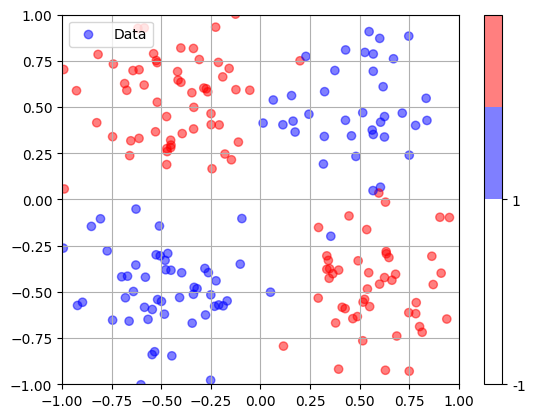

In [3]:
xTrain3, yTrain3 = generateBatchXor(200, sigma=0.25,seed=seed)
plotSvm(xTrain3, yTrain3)
xTest3, yTest3 = generateBatchXor(50, sigma=0.25,seed=seed)

First step is training the svm with the original kernel which is the Gaussian RBF kernel

$$
K(x,z) = \exp \left(-\frac{||x - z||^2}{2\sigma^2}\right),
$$

where $\sigma$ is a hyper-parameter. It's easiest to understand this kernel by viewing it as a similarity measure.

In [4]:
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
def custom_rbf_kernel(X, Y=None, gamma=1):
    if Y is None:
        Y = X
    X_norm = np.sum(X**2, axis=1).reshape(-1, 1)
    Y_norm = np.sum(Y**2, axis=1).reshape(1, -1)
    sq_dists = X_norm + Y_norm - 2 * np.dot(X, Y.T)
    return np.exp(-gamma * sq_dists)


svm_pre = svm.SVC(kernel=custom_rbf_kernel)
svm_pre.fit(xTrain3,yTrain3)
predictions = svm_pre.predict(xTest3)
accuracy_rbf = accuracy_score(yTest3, predictions)
print(accuracy_rbf)
support_indices = svm_pre.support_
support_vectors = xTrain3[support_indices]
dual = svm_pre.dual_coef_[0]

0.9


The accuracy for the unmodified kernel in this is 90%

(200, 200)


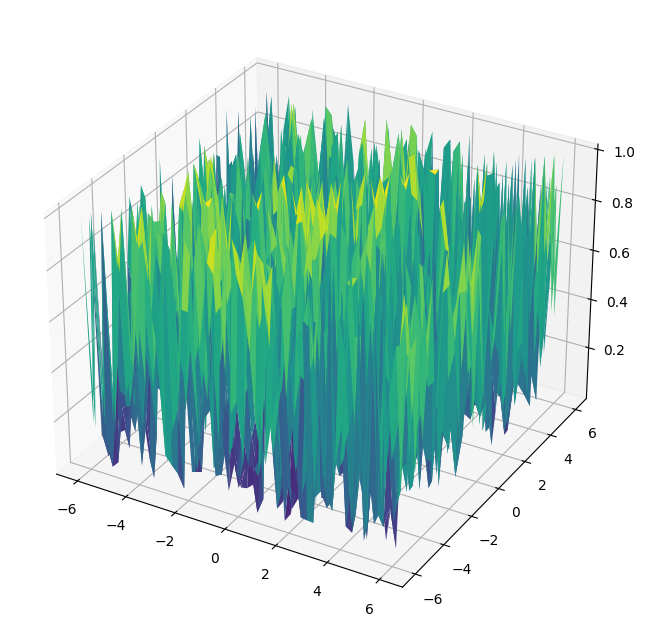

In [ ]:

Z = custom_rbf_kernel(xTrain3, xTrain3)
print(Z.shape)
X_plot, Y_plot = np.meshgrid(np.linspace(-6, 6, 50), np.linspace(-6, 6, 50))
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_plot, Y_plot, Z[:50, :50], cmap='viridis')

plt.show()

ok


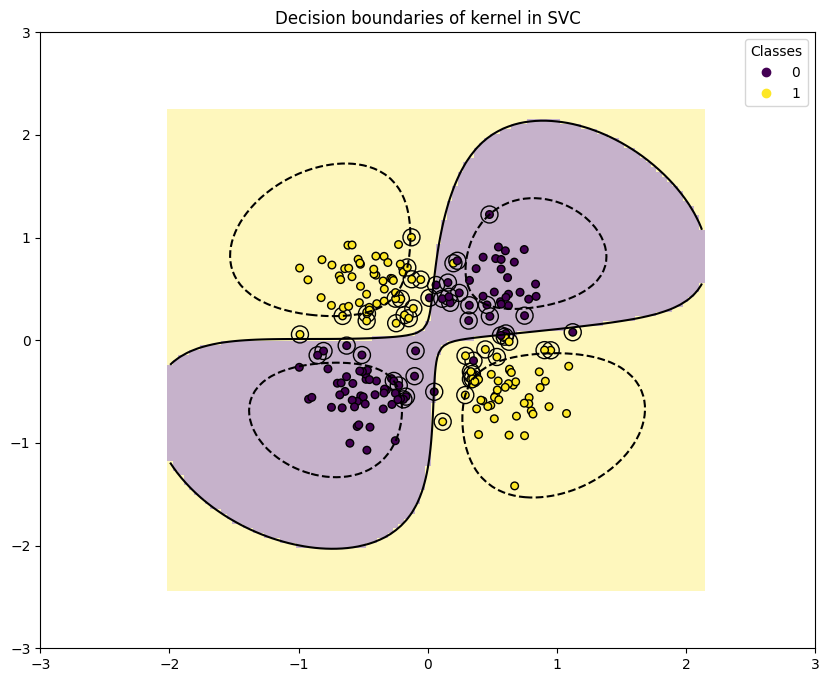

In [ ]:
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt
import numpy as np
X = xTrain3
y = yTrain3
scatter = ax.scatter(X[:, 0], X[:, 1], s=150, c=y, label=y, edgecolors="k")


def plot_training_data_with_decision_boundary(
    kernel='linear', ax=None, long_title=True, sv=None, clf=None):

    # Settings for plotting
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 8))  # Increased figure size

    x_min, x_max, y_min, y_max = -3, 3, -3, 3
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

    # Plot decision boundary and margins
    common_params = {"estimator": clf, "X": X, "ax": ax}
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="predict",
        plot_method="pcolormesh",
        alpha=0.3,
    )
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="decision_function",
        plot_method="contour",
        levels=[-1, 0, 1],
        colors=["k", "k", "k"],
        linestyles=["--", "-", "--"],
    )
    print("ok")

      # Plot bigger circles around samples that serve as support vectors
    ax.scatter(
      sv[:, 0],
      sv[:, 1],
      s=150,
      facecolors="none",
      edgecolors="k",
    )

    # Plot samples by color and add legend
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, s=30, edgecolors="k")
    ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    if long_title:
        ax.set_title(f"Decision boundaries of kernel in SVC")
    else:
        ax.set_title(kernel)

    if ax is None:
        plt.show()

# Call the function with the trained SVM model
plot_training_data_with_decision_boundary(sv= support_vectors,clf=svm_pre)

After the initial training and after obtaining the support vectors and the dual coefficients we will use the Amari and Wu conformal transformation of the kernel $c(x) = \sum_{i \in SVs} a_i e^{-\frac{||x - x_i||^2}{2t^2}} $ and modify the kernel by $K'(x,x')=c(x)c(x')K(x,x')$ where t is any number

In [5]:
t_values = np.linspace(0.1,10,500)


def modify_kernel(X,Y,t):
    c_X = np.sum(dual*custom_rbf_kernel(X,xTrain3[support_indices], gamma=1/(2*t**2)))
    c_Y = np.sum(dual*custom_rbf_kernel(Y,xTrain3[support_indices], gamma=1/(2*t**2)))
    return c_X*c_Y*custom_rbf_kernel(X,Y,gamma=1)

def kernel_function(t):
    def modified_kernel_closure(X, Y):
        return modify_kernel(X, Y, t=t)
    return modified_kernel_closure

best_accuracy = accuracy_rbf
print("accuracy before is ",best_accuracy)
second_best = 0
best_t = 1
best_sec = 0
for t in t_values:
    modify=kernel_function(t)
    svm1 = svm.SVC(kernel=modify)
    svm1.fit(xTrain3,yTrain3)
    predictions5 = svm1.predict(xTest3)
    accuracy = accuracy_score(yTest3, predictions5)
    print("t is ",t,"accuracy is",accuracy)
    if accuracy >= accuracy_rbf and accuracy> best_accuracy:
        best_accuracy = accuracy
        best_t = t
        predictions_modified_best = predictions5
    elif accuracy >= second_best:
        second_best = accuracy
        best_sec = t

accuracy before is  0.9
t is  0.1 accuracy is 0.94
t is  0.11983967935871745 accuracy is 0.94
t is  0.13967935871743486 accuracy is 0.94
t is  0.1595190380761523 accuracy is 0.94
t is  0.17935871743486975 accuracy is 0.94
t is  0.1991983967935872 accuracy is 0.94
t is  0.21903807615230464 accuracy is 0.92
t is  0.23887775551102206 accuracy is 0.86
t is  0.2587174348697395 accuracy is 0.8
t is  0.27855711422845697 accuracy is 0.76
t is  0.2983967935871744 accuracy is 0.76
t is  0.3182364729458918 accuracy is 0.76
t is  0.33807615230460925 accuracy is 0.76
t is  0.35791583166332663 accuracy is 0.72
t is  0.3777555110220441 accuracy is 0.68
t is  0.3975951903807615 accuracy is 0.66
t is  0.41743486973947896 accuracy is 0.56
t is  0.4372745490981964 accuracy is 0.52
t is  0.45711422845691385 accuracy is 0.5
t is  0.4769539078156313 accuracy is 0.5
t is  0.49679358717434874 accuracy is 0.48
t is  0.5166332665330662 accuracy is 0.44
t is  0.5364729458917836 accuracy is 0.4
t is  0.5563126252

In [13]:
print("best t is ",best_t,"accuracy is",best_accuracy)

best t is  0.8539078156312626 accuracy is 0.96


The best t for this was 0.85 and the accuracy got improved by 6% correcting the misclassification of 3 data points

In [7]:
modify=kernel_function(best_t)
svm1 = svm.SVC(kernel=modify)
svm1.fit(xTrain3,yTrain3)

SVC(kernel=<function kernel_function.<locals>.modified_kernel_closure at 0x7c77f036d360>)

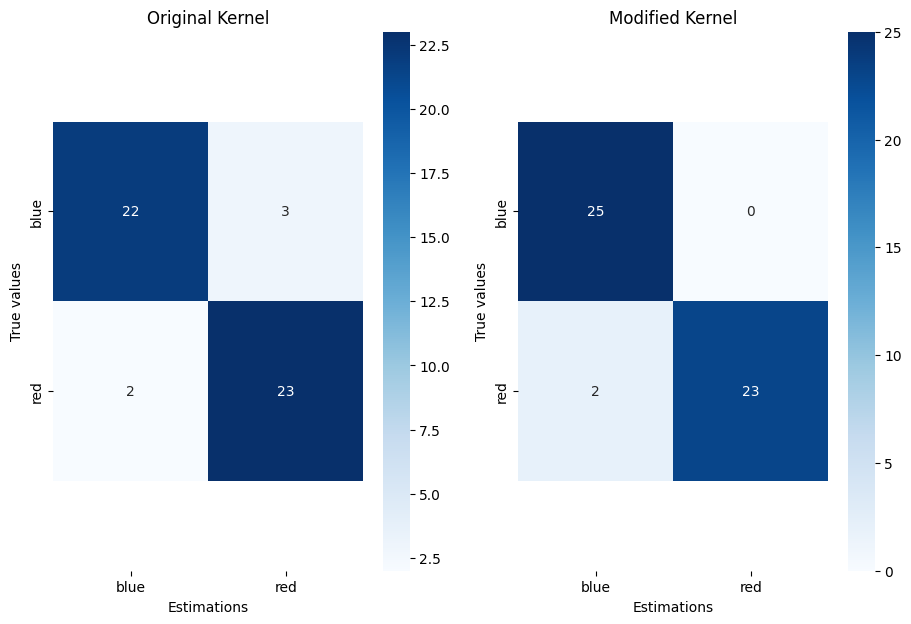

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(11, 7))
titles = ["Original Kernel", "Modified Kernel"]
for yEst, ax, title in zip([predictions, predictions_modified_best], axes, titles):
        # self.plotConfusionMatrix(yTest, yEst, colors, title, ax)
        plotConfusionMatrix(yTest3, yEst,colors, title, ax=ax)
plt.show()

(200, 200)


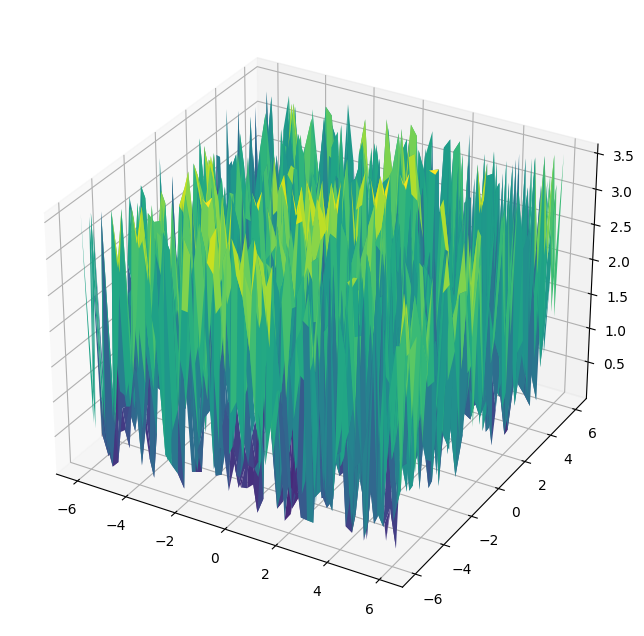

In [ ]:
kernel_func = kernel_factory(0.8539078156312626)
Z = kernel_func(xTrain3, xTrain3)
print(Z.shape)
X_plot, Y_plot = np.meshgrid(np.linspace(-6, 6, 50), np.linspace(-6, 6, 50))
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_plot, Y_plot, Z[:50, :50], cmap='viridis')

plt.show()

(38, 2)
ok


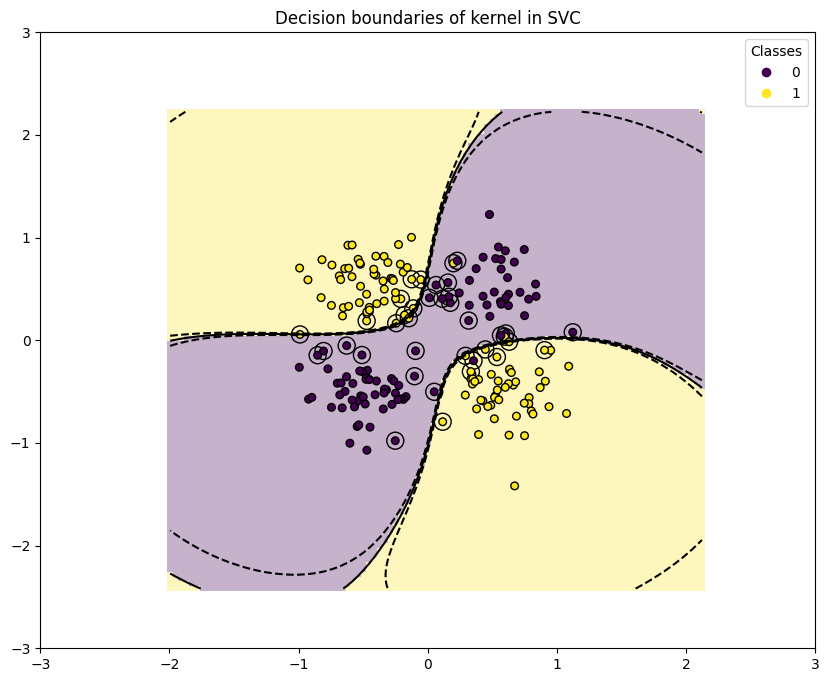

In [ ]:
support_indices2 = svm1.support_
support_vectors_1 = xTrain3[support_indices2]
print(support_vectors_1.shape)
plot_training_data_with_decision_boundary(sv = support_vectors_1,clf=svm1)

In [8]:
t_values = np.linspace(0.1,10,500)
support_vector_labels = yTrain3[support_indices]


Below is the implementation of the improved conformal transformation that Amari and Wu suggested in 2002 where now $ c_2(x) = \sum_{i \in SV} e^{-\frac{||x - x_i||^2}{2\tau_i^2}}$,where $\tau_i = \frac{1}{M} \sum_{j \in \{M \subset SV\}} ||x_j - x_i||^2. $
The summation in runs over $M$ support vectors that are nearest to support vector ($x_i)$. $M$ is a parameter that needs to be adjusted.


In [12]:
def confScaling(X,tau_i_list=best_tau):
      confScaling = np.zeros(X.shape[0])

      for i in range(X.shape[0]):
          # Iterate over each support vector
          for a in range(support_vectors.shape[0]):
              # Calculate the difference vector

              v = X[i, :] - support_vectors[a, :]
              n = -np.sum(v * v) / (2 * tau_i_list[a] ** 2)
              confScaling[i] += np.exp(n)
      return confScaling

In [10]:
def norm(X,Y):
    X_norm = np.sum(X**2, axis=1).reshape(-1, 1)
    Y_norm = np.sum(Y**2, axis=1).reshape(1, -1)
    sq_dists = X_norm + Y_norm - 2 * np.dot(X, Y.T)
    return sq_dists

def modify_kernel_D2(X, Y,t):
    c_X = confScaling(X,t).reshape(-1, 1)
    c_Y = confScaling(Y,t).reshape(1, -1)
    rbf = custom_rbf_kernel(X, Y, gamma=1)
    return c_X * c_Y * rbf



def kernel_function_D2(t):
    def modified_kernel_closure_D2(X, Y):
        return modify_kernel_D2(X, Y, t=t)
    return modified_kernel_closure_D2


In [ ]:
print(support_vectors.shape)

(57, 2)


In [11]:
best_accuracy = 0
best_tau = []
def confScaling(X,tau_i_list=best_tau):
      confScaling = np.zeros(X.shape[0])

      for i in range(X.shape[0]):
          # Iterate over each support vector
          for a in range(support_vectors.shape[0]):
              # Calculate the difference vector

              v = X[i, :] - support_vectors[a, :]
              n = -np.sum(v * v) / (2 * tau_i_list[a] ** 2)
              confScaling[i] += np.exp(n)
      return confScaling
for M in range(len(support_vectors)):
    tau_i_list = []
    if  M==0 or M==1 or M==2:
        continue
    for xi in support_vectors:
        distances = np.linalg.norm(support_vectors - xi, axis=1) ** 2  # Squared distances
        sorted_indices = np.argsort(distances)  # Sort indices based on distances
        nearest_indices = sorted_indices[1:M+1]  # Exclude the point itself, select M nearest points
        nearest_support_vectors = support_vectors[nearest_indices]
        tau_i_sum = np.sum(distances[nearest_indices])
        tau_i = tau_i_sum / M
        tau_i_list.append(tau_i)

    tau_i_list = np.array(tau_i_list)
    second_best = 0
    best_sec = 0
    modify=kernel_function_D2(tau_i_list)
    svm2 = svm.SVC(kernel=modify)
    svm2.fit(xTrain3,yTrain3)
    predictions5 = svm2.predict(xTest3)
    accuracy = accuracy_score(yTest3, predictions5)
    print("M is ",M,"accuracy is",accuracy)
    if accuracy >= accuracy_rbf and accuracy> best_accuracy:
      best_accuracy = accuracy
      best_M = M
      predictions_modified_best = predictions5
      best_tau = tau_i_list
    elif accuracy >= second_best:
      second_best = accuracy
      best_sec = M
print("Best t is ",best_M,"accuracy is",best_accuracy)

M is  3 accuracy is 0.54
M is  4 accuracy is 0.58
M is  5 accuracy is 0.62
M is  6 accuracy is 0.72
M is  7 accuracy is 0.72
M is  8 accuracy is 0.74
M is  9 accuracy is 0.82
M is  10 accuracy is 0.84
M is  11 accuracy is 0.86
M is  12 accuracy is 0.9
M is  13 accuracy is 0.9
M is  14 accuracy is 0.92
M is  15 accuracy is 0.94
M is  16 accuracy is 0.94
M is  17 accuracy is 0.94
M is  18 accuracy is 0.94
M is  19 accuracy is 0.94
M is  20 accuracy is 0.94
M is  21 accuracy is 0.94
M is  22 accuracy is 0.94
M is  23 accuracy is 0.94
M is  24 accuracy is 0.94
M is  25 accuracy is 0.94
M is  26 accuracy is 0.94
M is  27 accuracy is 0.94
M is  28 accuracy is 0.94
M is  29 accuracy is 0.94
M is  30 accuracy is 0.94
M is  31 accuracy is 0.94
M is  32 accuracy is 0.94
M is  33 accuracy is 0.94
M is  34 accuracy is 0.94
M is  35 accuracy is 0.94
M is  36 accuracy is 0.94
M is  37 accuracy is 0.94
M is  38 accuracy is 0.94
M is  39 accuracy is 0.94
M is  40 accuracy is 0.94
M is  41 accuracy is 

Here the best accuracy is achieved for M = 42 and overall the accuracy improved from 90% to 96%

In [ ]:
modify=kernel_factory_D2(best_tau)
svm2 = svm.SVC(kernel=modify)
svm2.fit(xTrain3,yTrain3)
support_indices3 = svm2.support_
support_vectors_2 = xTrain3[support_indices3]

(200, 200)


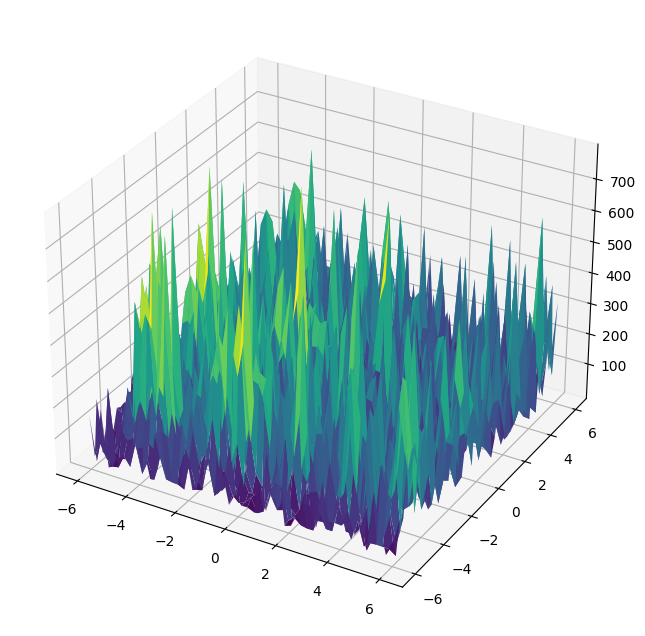

In [ ]:
kernel_func = kernel_factory_D2(best_tau)
Z = kernel_func(xTrain3, xTrain3)
print(Z.shape)
X_plot, Y_plot = np.meshgrid(np.linspace(-6, 6, 50), np.linspace(-6, 6, 50))
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_plot, Y_plot, Z[:50, :50], cmap='viridis')

plt.show()

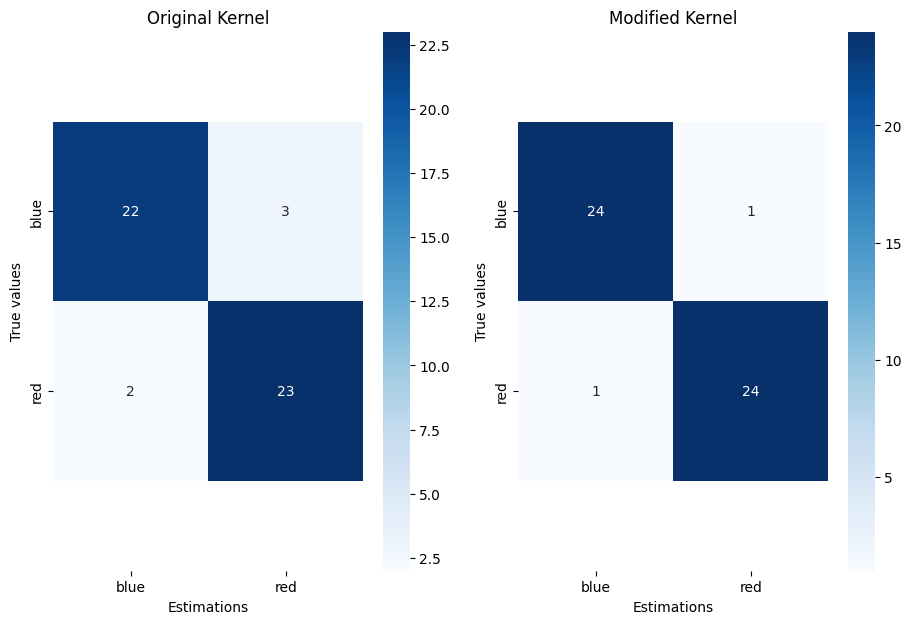

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(11, 7))
titles = ["Original Kernel", "Modified Kernel"]
for yEst, ax, title in zip([predictions, predictions_modified_best], axes, titles):
        # self.plotConfusionMatrix(yTest, yEst, colors, title, ax)
        plotConfusionMatrix(yTest3, yEst,colors, title, ax=ax)
plt.show()

In [ ]:
def plot_training_data_with_decision_boundary(
    kernel='linear', ax=None, long_title=True, sv=None, clf=None):

    # Settings for plotting
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 8))  # Increased figure size

    x_min, x_max, y_min, y_max = -3, 3, -3, 3
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
    # Plot decision boundary and margins
    common_params = {"estimator": clf, "X": X, "ax": ax}
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="predict",
        plot_method="pcolormesh",
        alpha=0.3,
    )
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="decision_function",
        plot_method="contour",
        levels=[-1, 0, 1],
        colors=["k", "k", "k"],
        linestyles=["--", "-", "--"],
    )

      # Plot bigger circles around samples that serve as support vectors
    ax.scatter(
      sv[:, 0],
      sv[:, 1],
      s=150,
      facecolors="none",
      edgecolors="k",
    )

    # Plot samples by color and add legend
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, s=30, edgecolors="k")
    ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    if long_title:
        ax.set_title(f"Decision boundaries of kernel in SVC")
    else:
        ax.set_title(kernel)

    if ax is None:
        plt.show()

(18, 2)


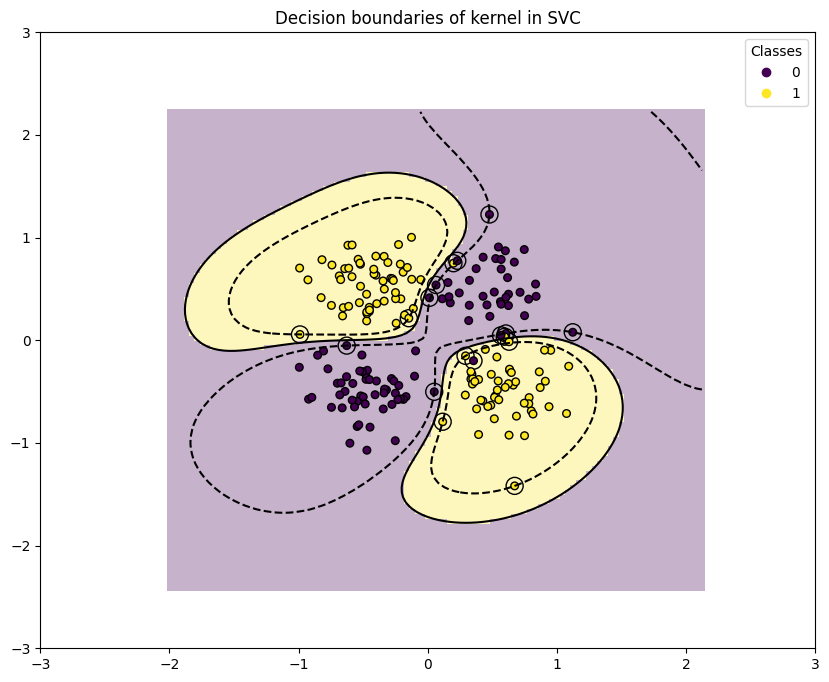

In [ ]:
print(support_vectors_2.shape)
plot_training_data_with_decision_boundary(sv=support_vectors_2,clf=svm2)

In [ ]:
seed_arr = np.linspace(1,100,100)
for seed in seed_arr:
    xTrain3, yTrain3 = generateBatchXor(200, sigma=0.25,seed=seed)
    plotSvm(xTrain3, yTrain3)
    xTest3, yTest3 = generateBatchXor(50, sigma=0.25,seed=seed)
    svm_pre = svm.SVC(kernel=custom_rbf_kernel)
    svm_pre.fit(xTrain3,yTrain3)
    predictions = svm_pre.predict(xTest3)
    accuracy_rbf = accuracy_score(yTest3, predictions)
    print(accuracy_rbf)
    support_indices = svm_pre.support_
    support_vectors = xTrain3[support_indices]
    dual = svm_pre.dual_coef_[0]
    second_best = 0
    best_t = 1
    best_sec = 0
    best_accuracy = 0
    for t in t_values:
        modify=kernel_factory(t)
        svm1 = svm.SVC(kernel=modify)
        svm1.fit(xTrain3,yTrain3)
        predictions5 = svm1.predict(xTest3)
        accuracy = accuracy_score(yTest3, predictions5)
        print("t is ",t,"accuracy is",accuracy)
        if accuracy> best_accuracy:
            best_accuracy = accuracy
            best_t = t
            predictions_modified_best = predictions5
        elif accuracy >= second_best:
            second_best = accuracy
            best_sec = t
    print("best t is ",best_t,"accuracy is",best_accuracy)
    best_accuracy_2 = 0
    best_tau = []
    for M in range(len(support_vectors)):
        tau_i_list = []
        if  M==0 or M==1 or M==2:
            continue
        for xi in support_vectors:
            distances = np.linalg.norm(support_vectors - xi, axis=1) ** 2  # Squared distances
            sorted_indices = np.argsort(distances)  # Sort indices based on distances
            nearest_indices = sorted_indices[1:M+1]  # Exclude the point itself, select M nearest points
            nearest_support_vectors = support_vectors[nearest_indices]
            tau_i_sum = np.sum(distances[nearest_indices])
            tau_i = tau_i_sum / M
            tau_i_list.append(tau_i)

        tau_i_list = np.array(tau_i_list)
        second_best = 0
        best_sec = 0
        modify=kernel_factory_D2(tau_i_list)
        svm2 = svm.SVC(kernel=modify)
        svm2.fit(xTrain3,yTrain3)
        predictions5 = svm2.predict(xTest3)
        accuracy = accuracy_score(yTest3, predictions5)
        print("M is ",M,"accuracy is",accuracy)
        if accuracy> best_accuracy_2:
          best_accuracy_2 = accuracy
          best_M = M
          predictions_modified_best = predictions5
          best_tau = tau_i_list
        elif accuracy >= second_best:
          second_best = accuracy
          best_sec = M
    print("Best t is ",best_M,"accuracy is",best_accuracy_2)


<ipython-input-38-ebef31ce012a>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1)


NameError: name 'pd' is not defined

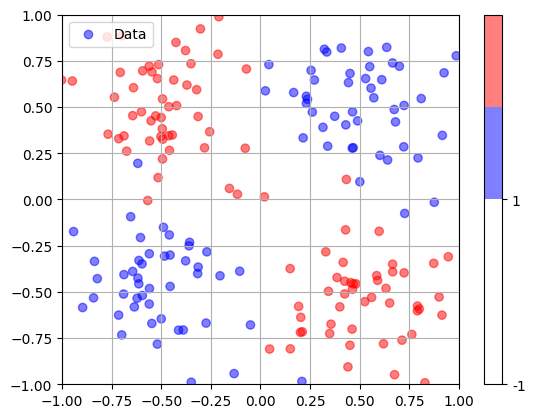

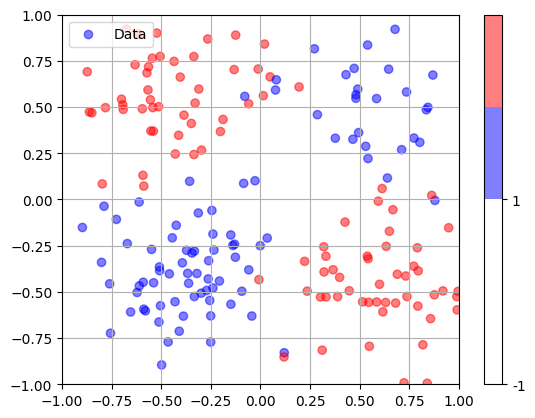

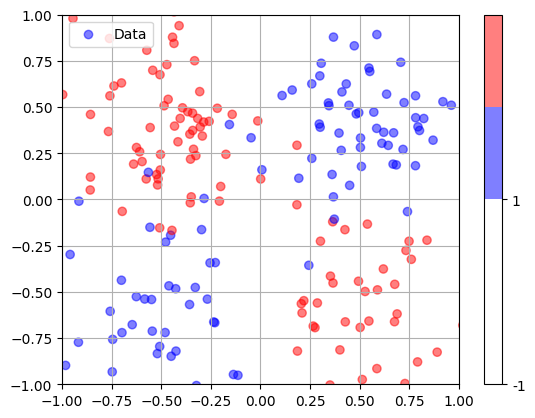

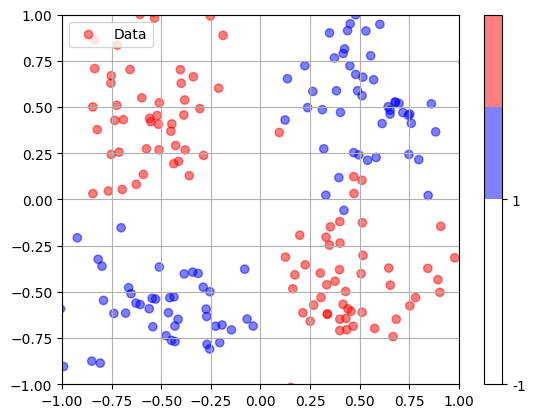

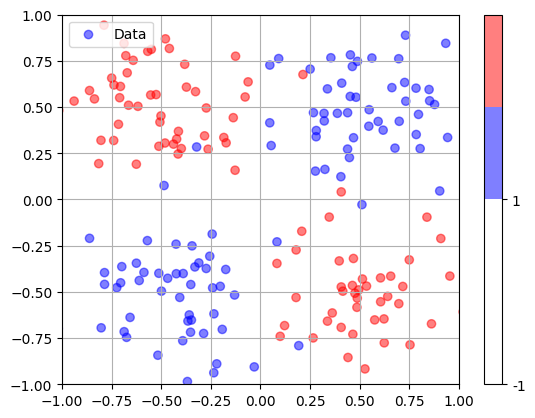

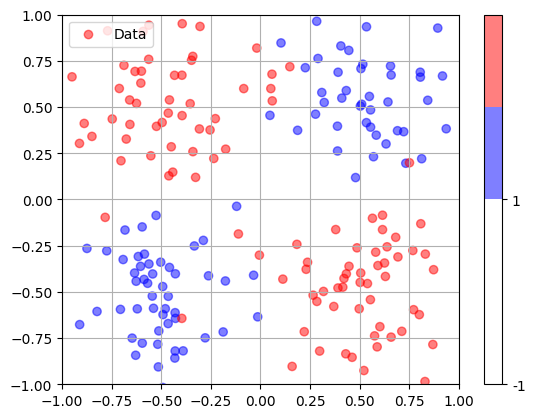

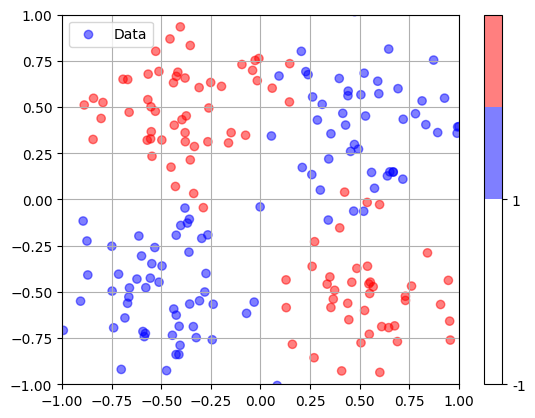

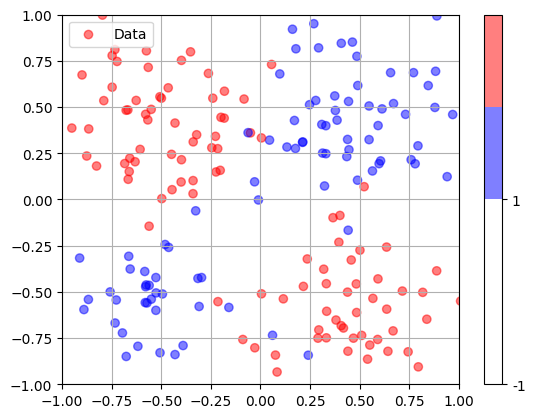

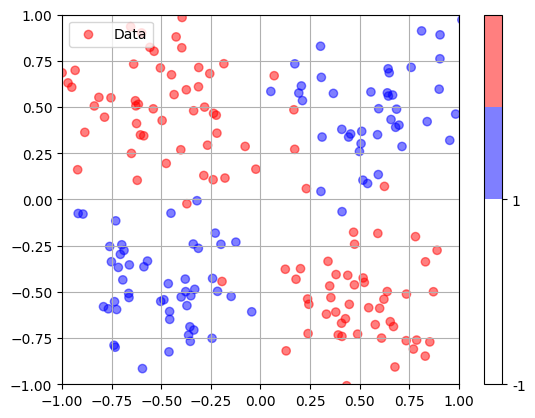

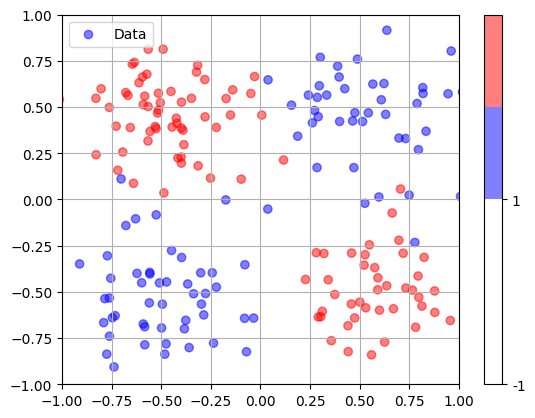

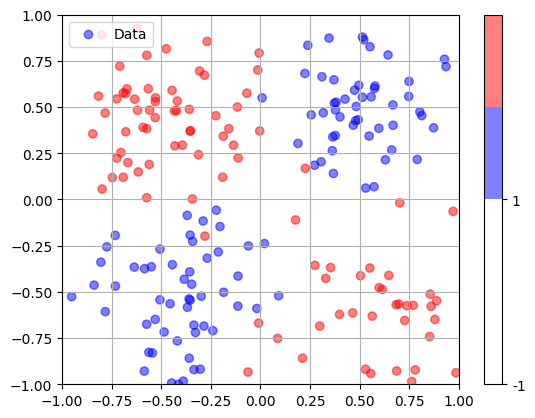

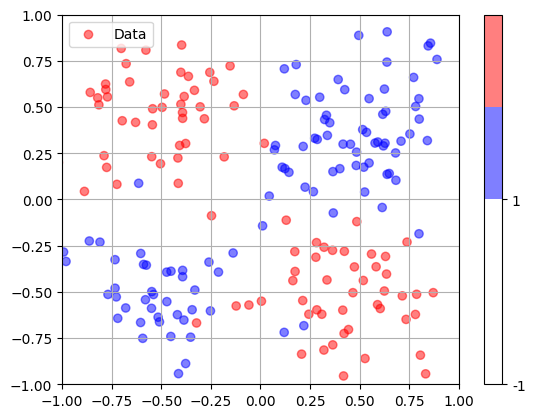

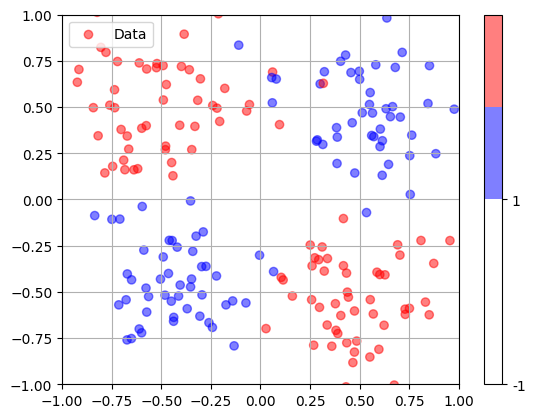

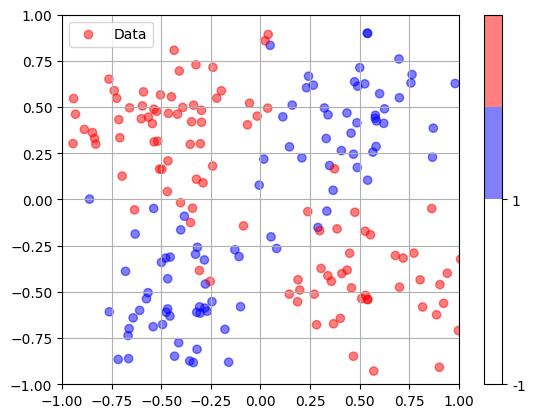

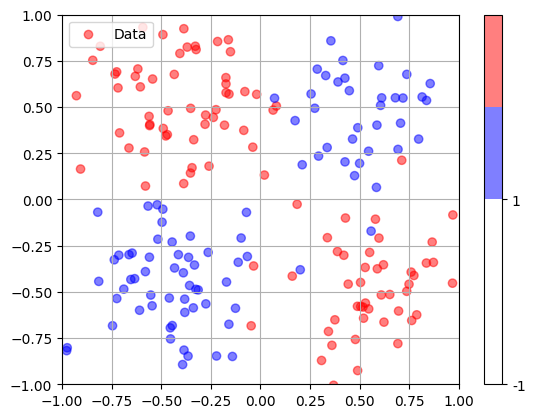

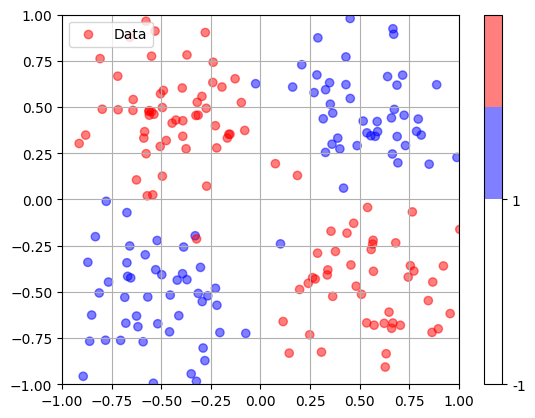

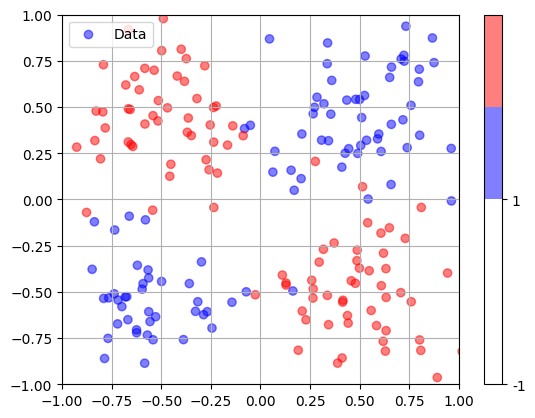

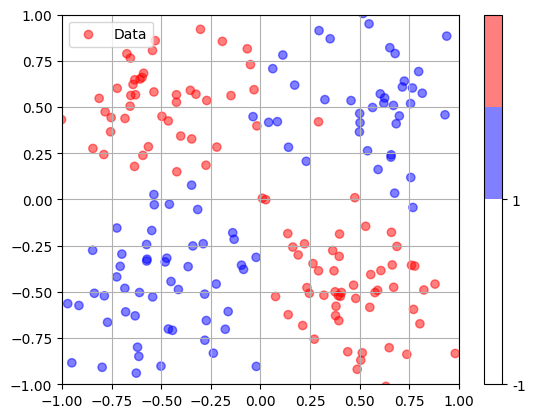

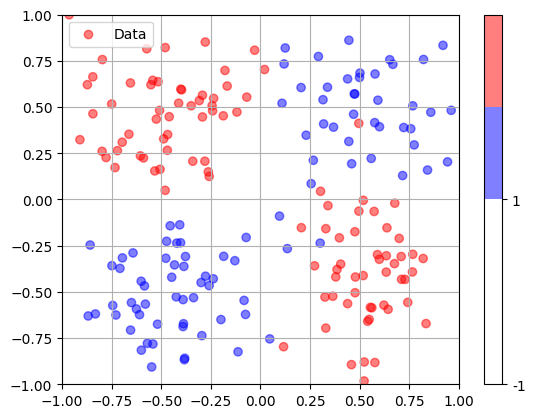

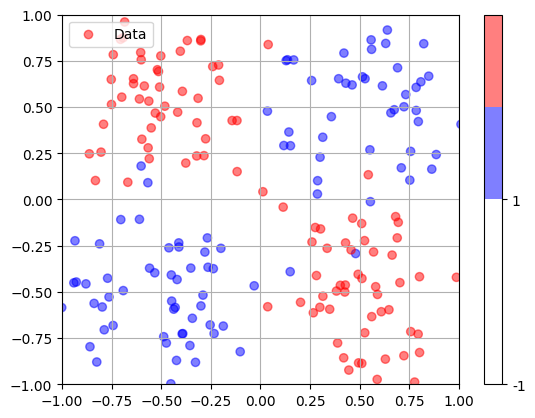

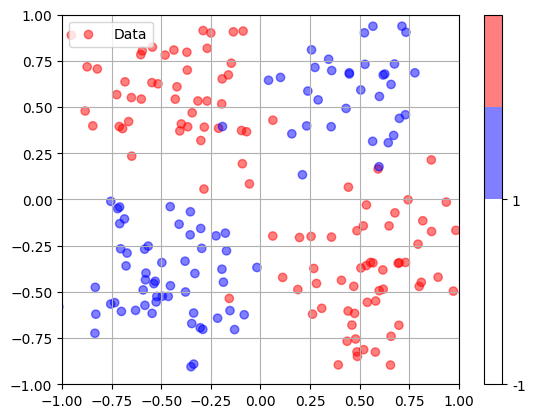

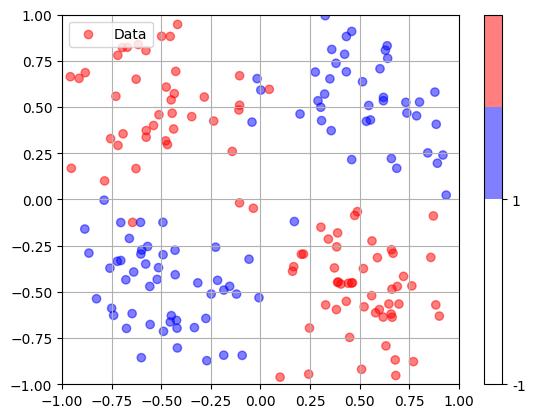

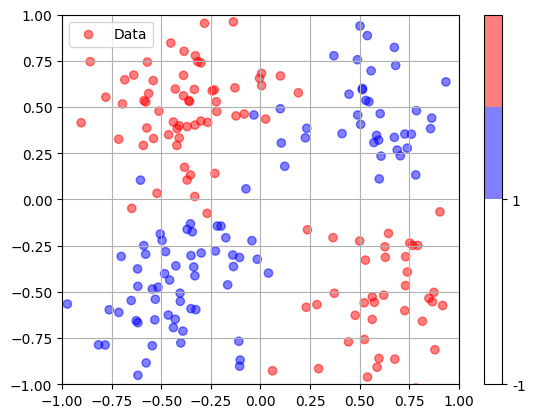

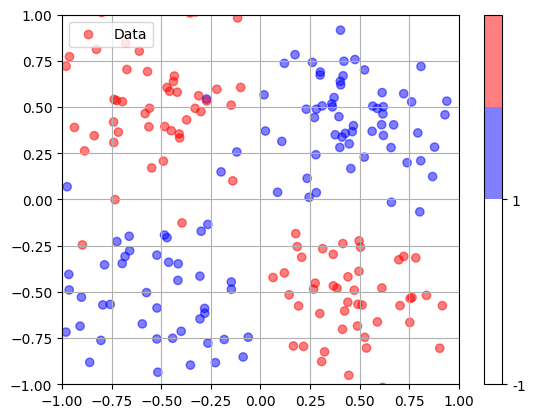

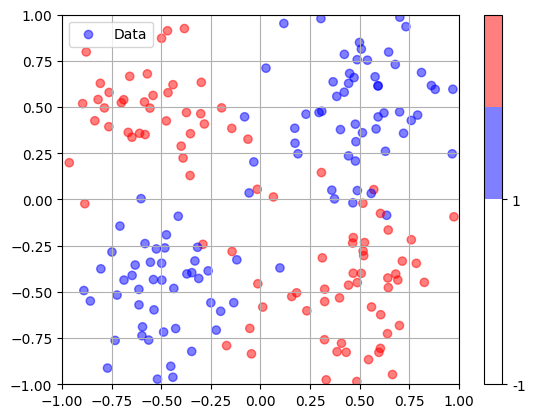

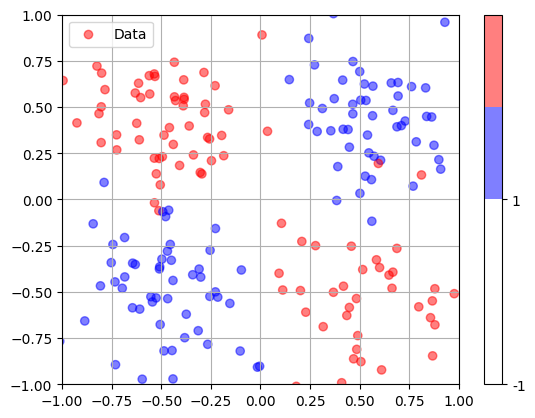

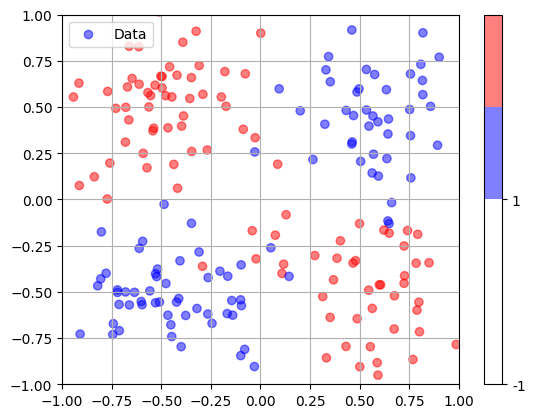

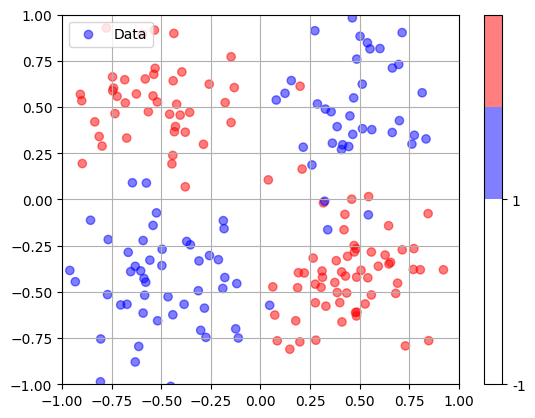

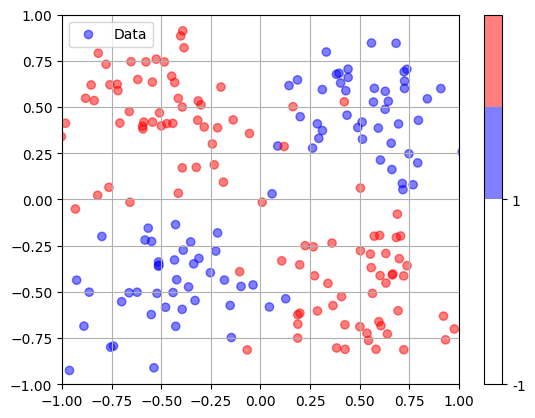

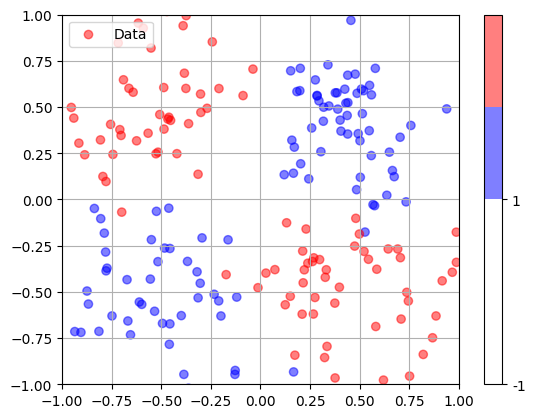

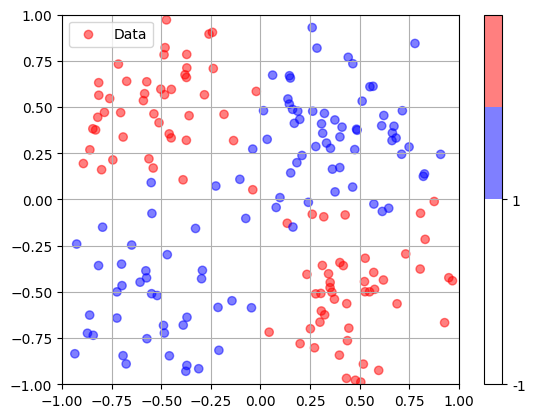

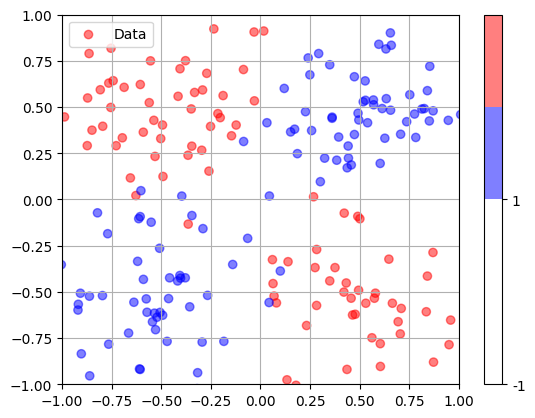

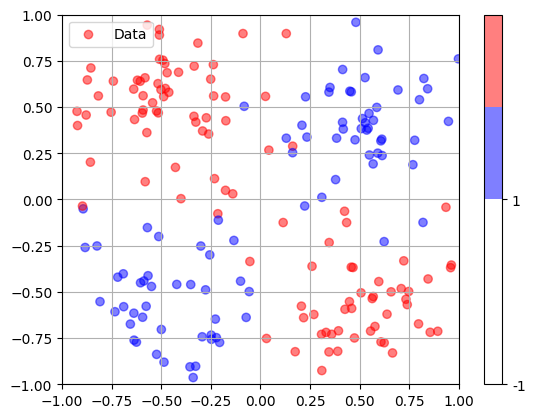

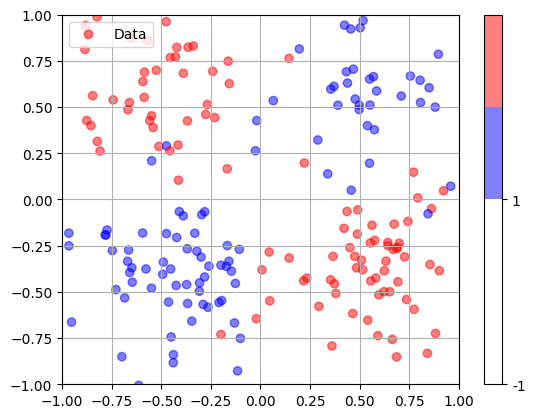

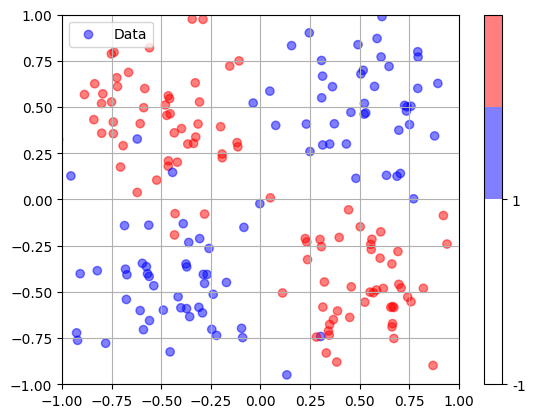

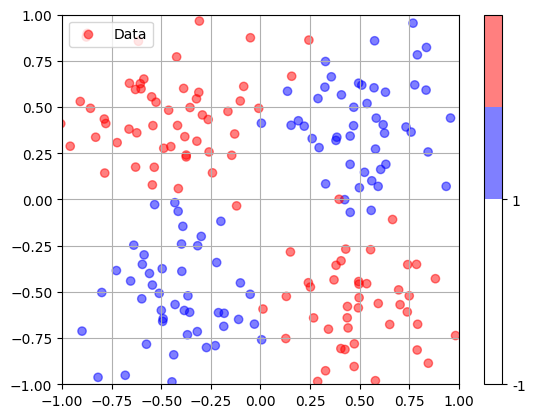

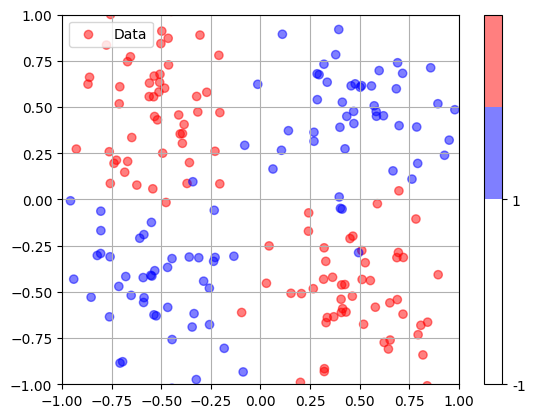

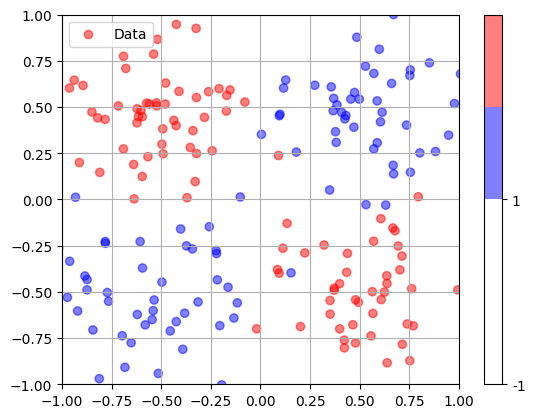

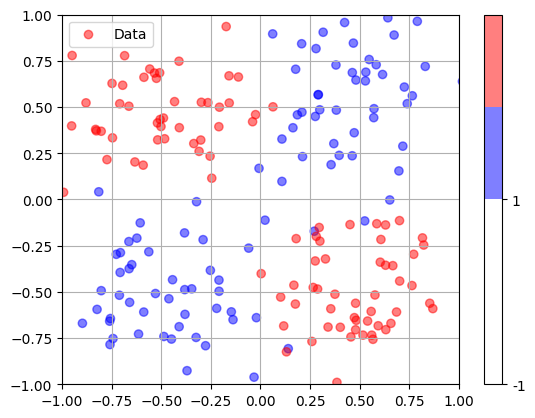

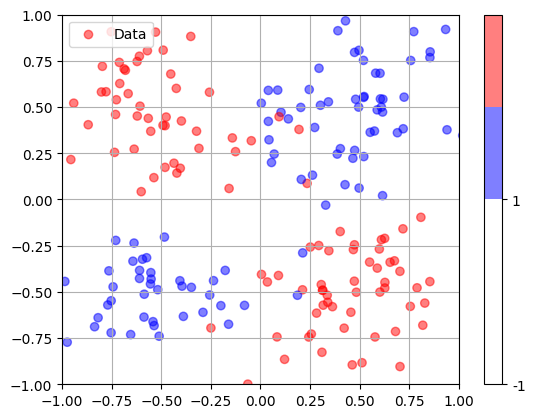

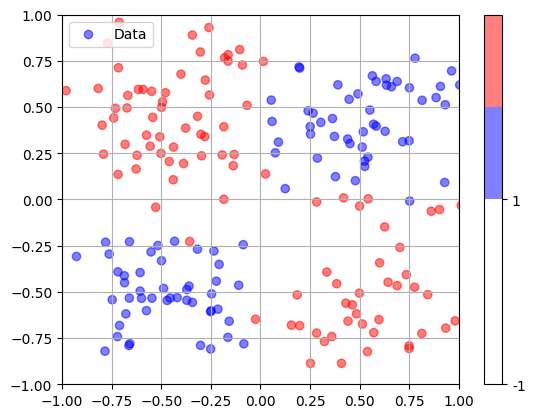

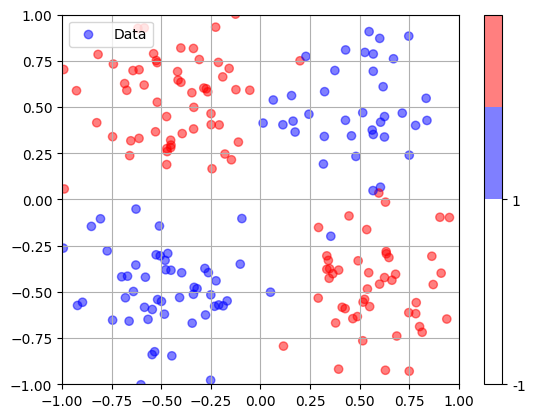

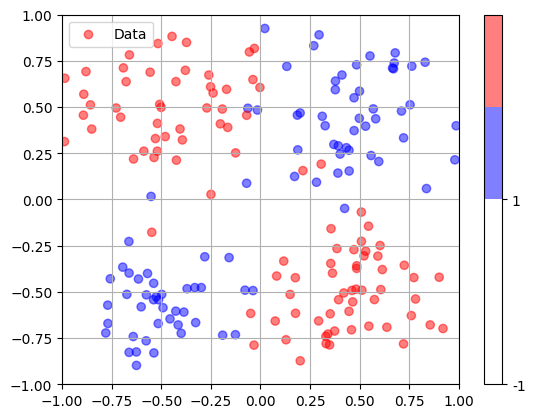

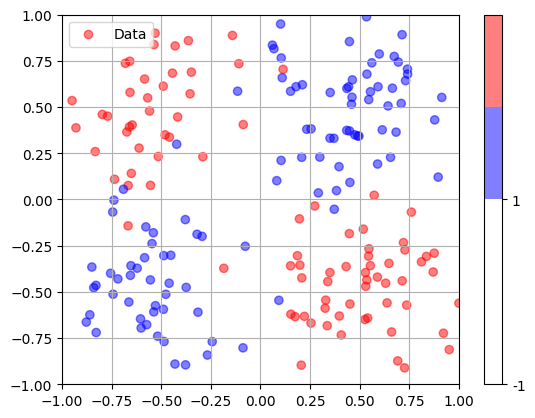

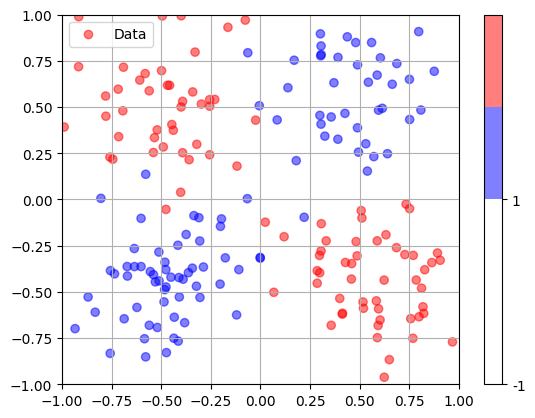

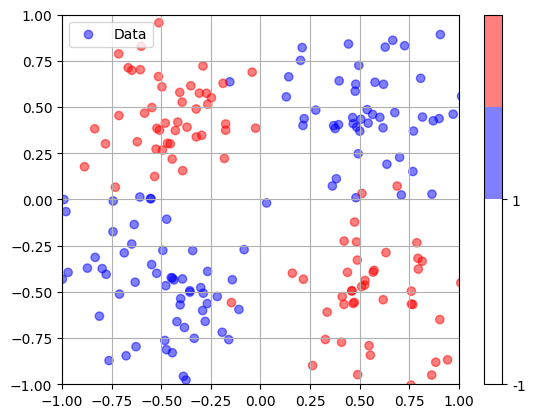

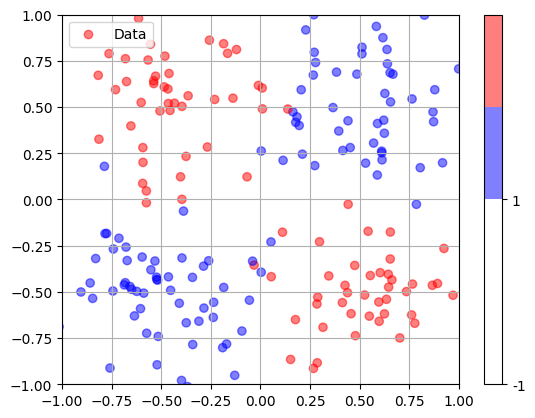

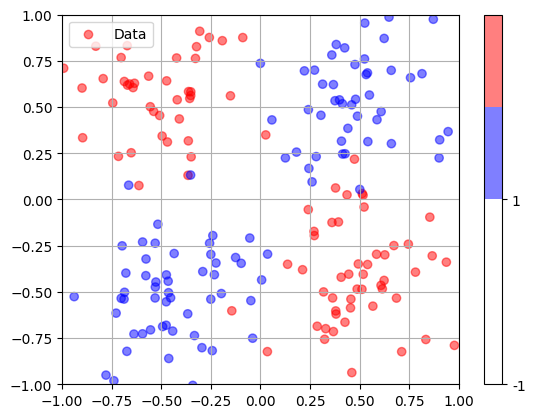

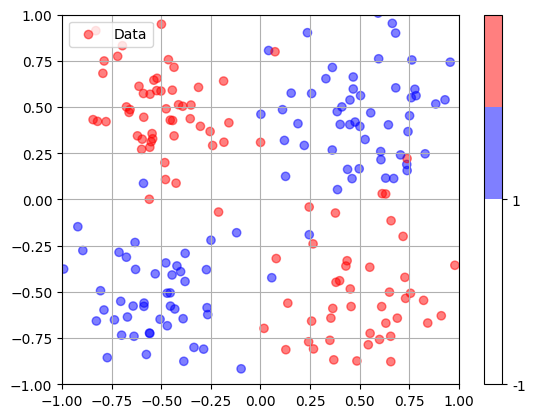

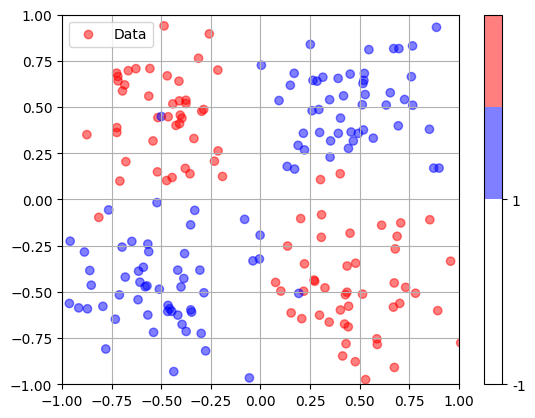

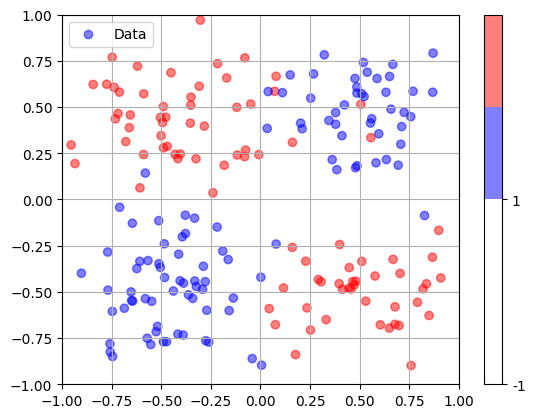

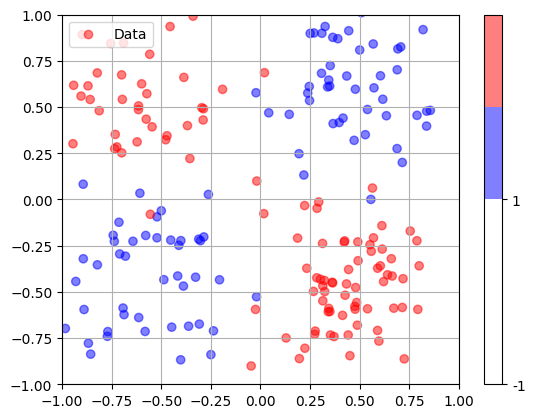

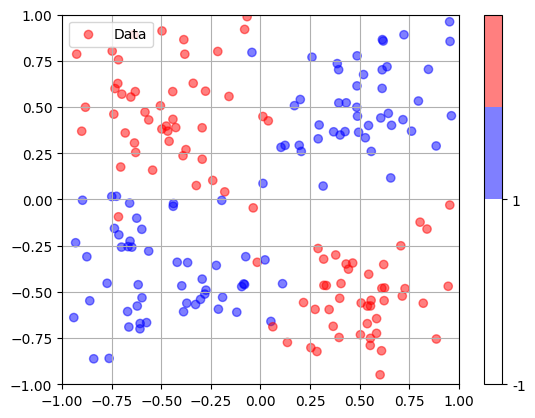

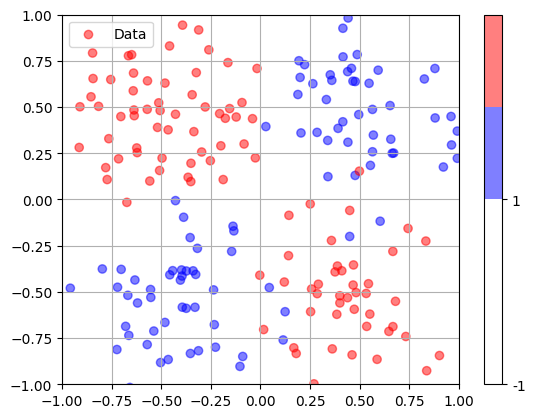

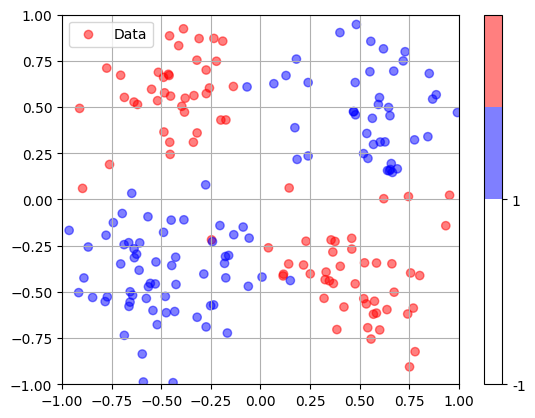

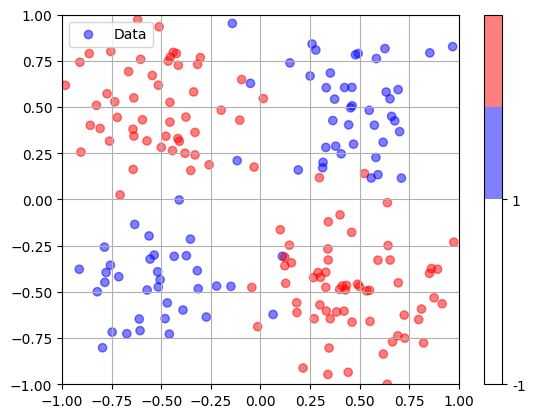

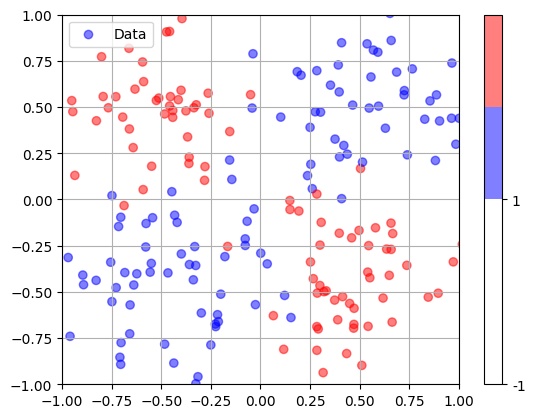

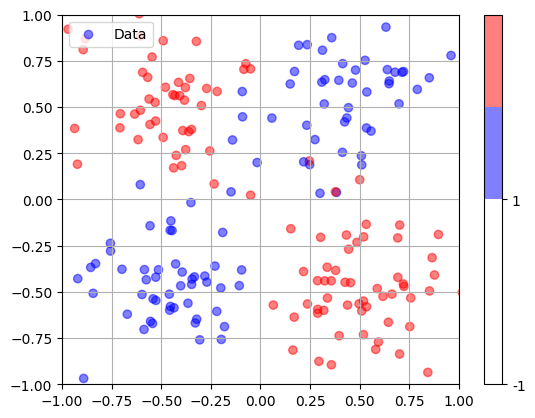

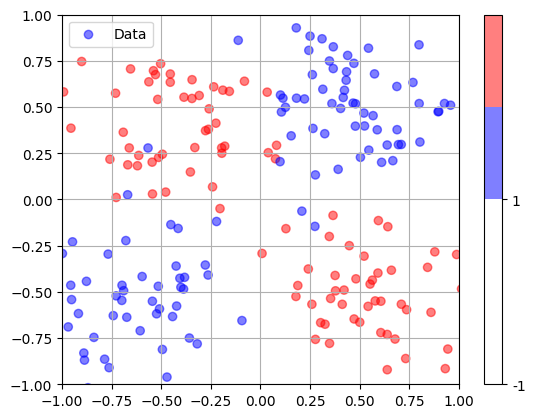

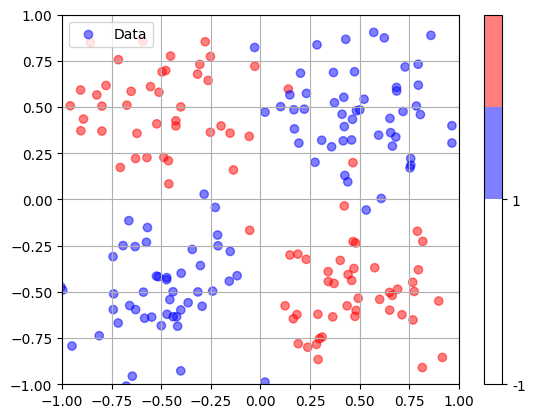

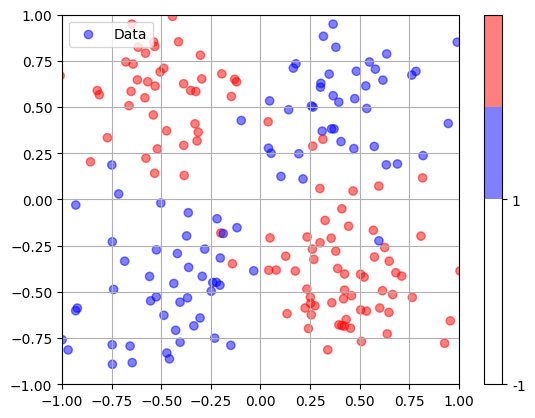

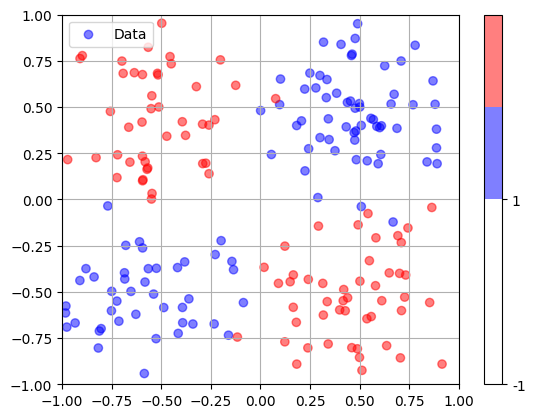

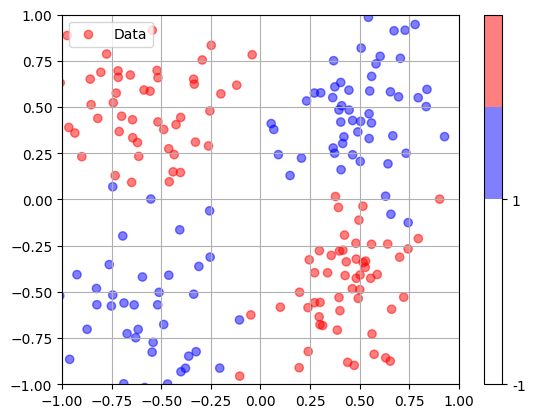

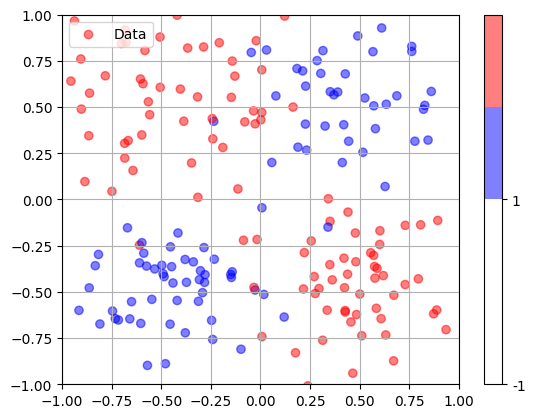

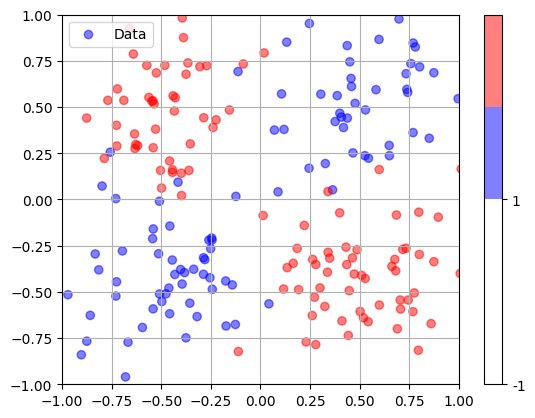

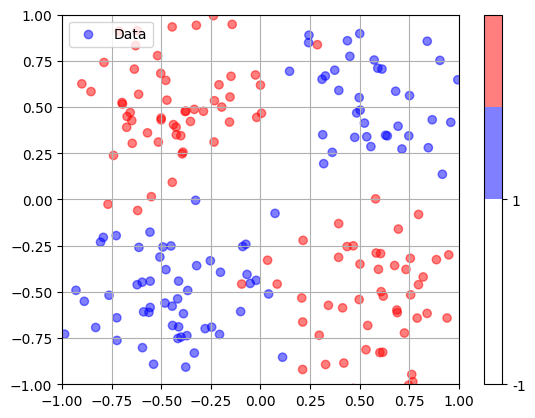

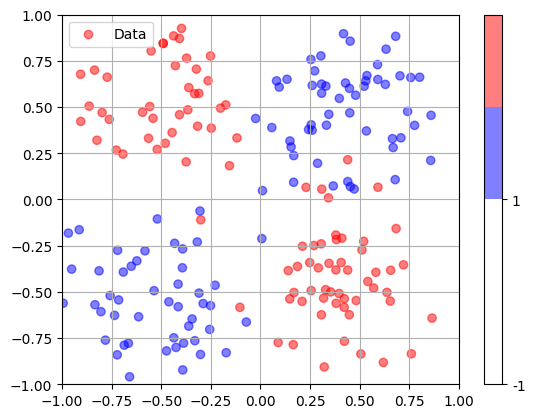

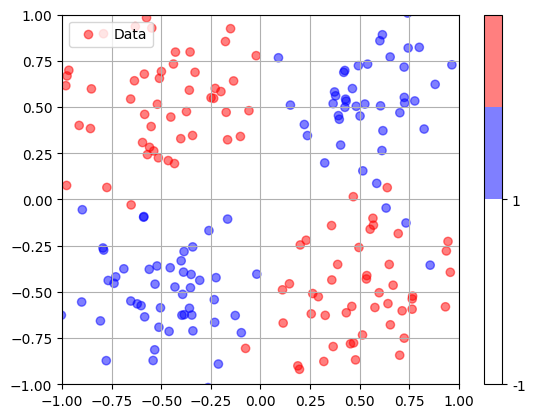

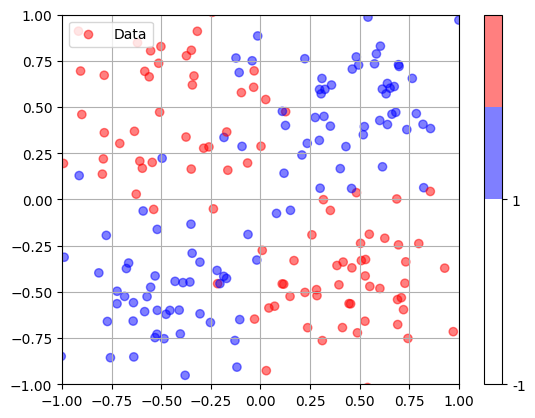

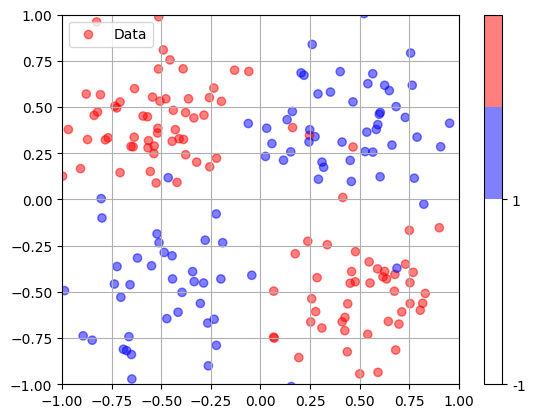

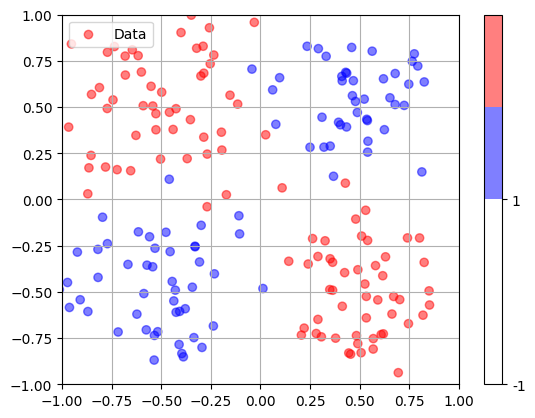

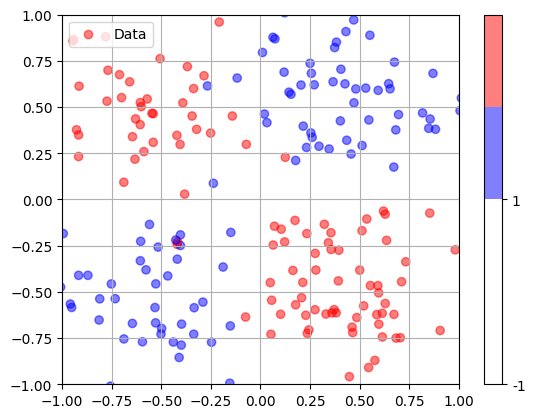

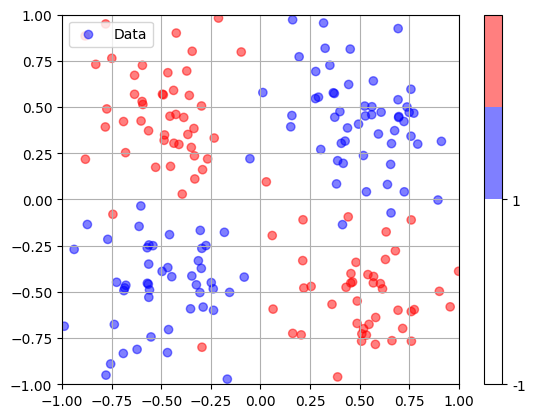

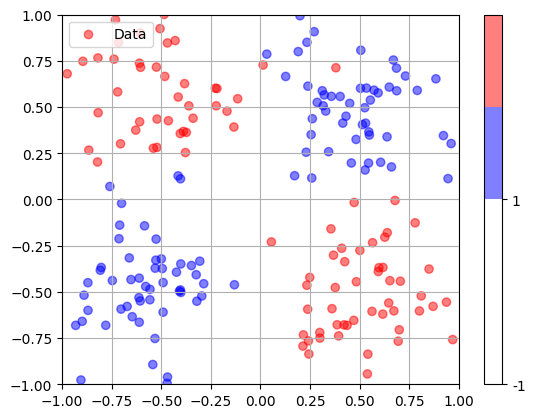

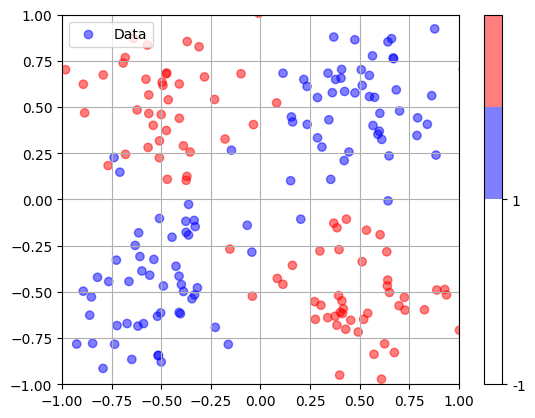

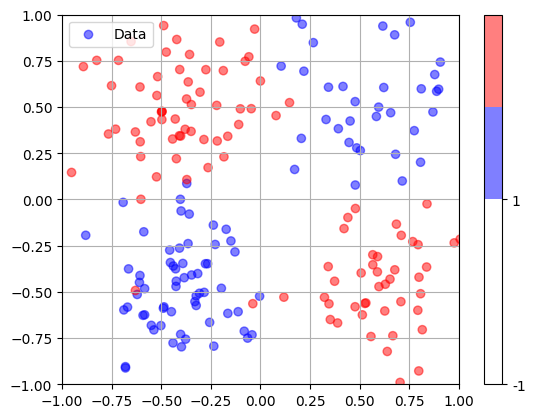

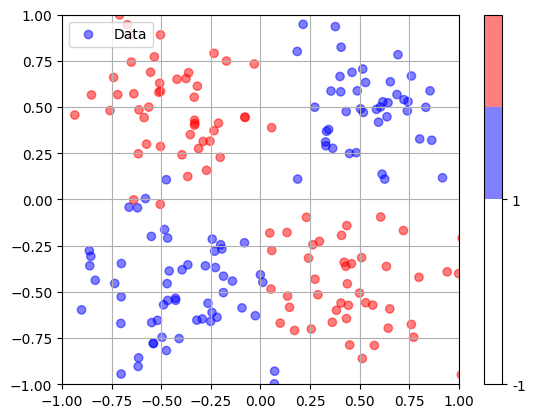

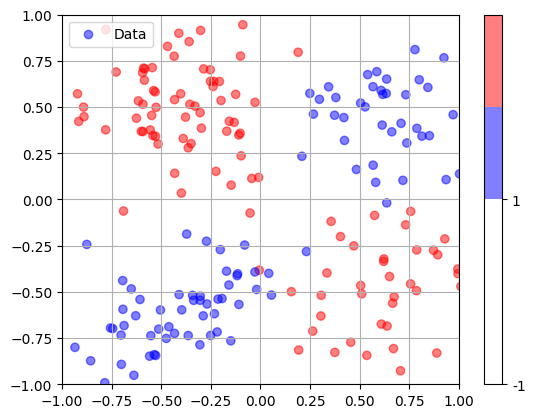

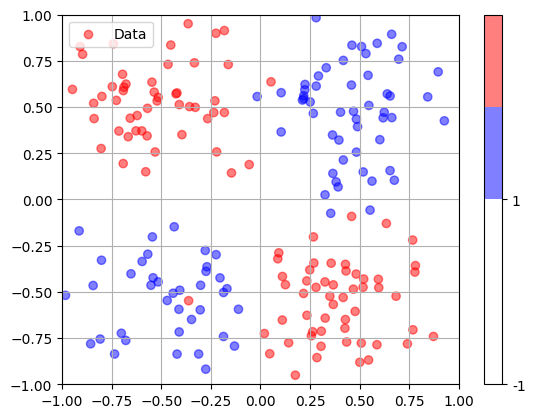

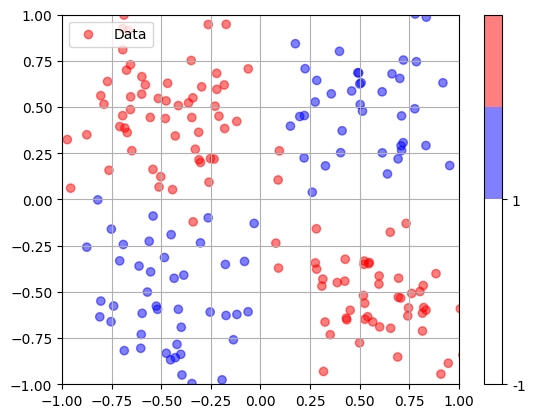

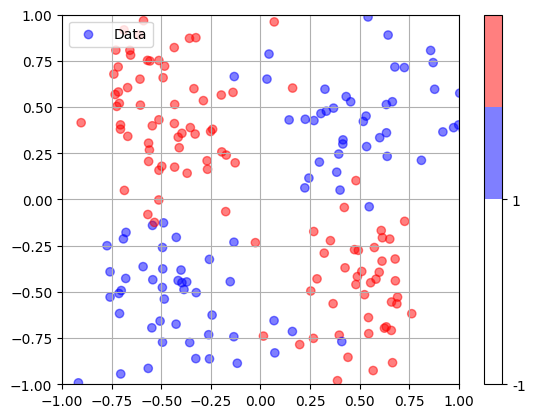

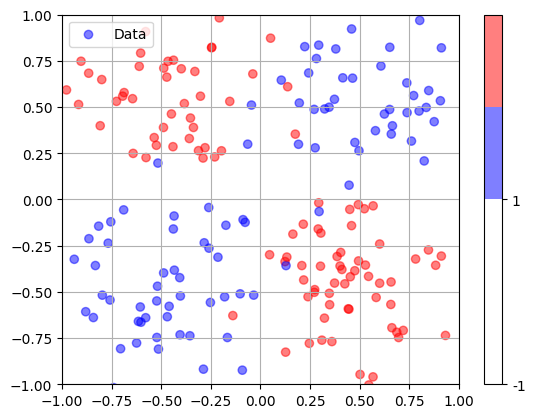

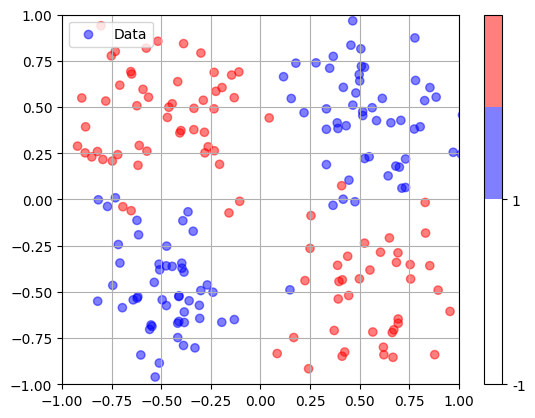

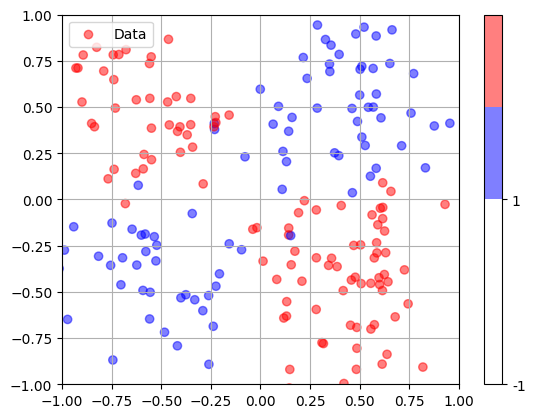

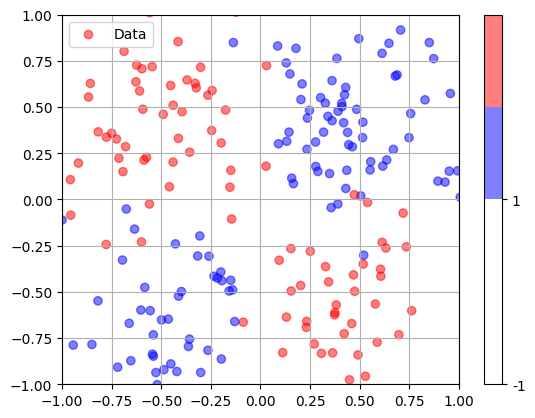

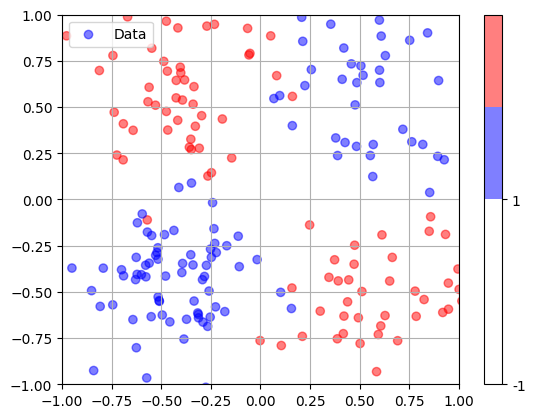

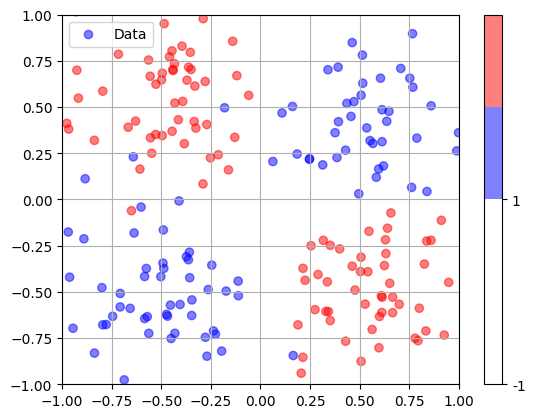

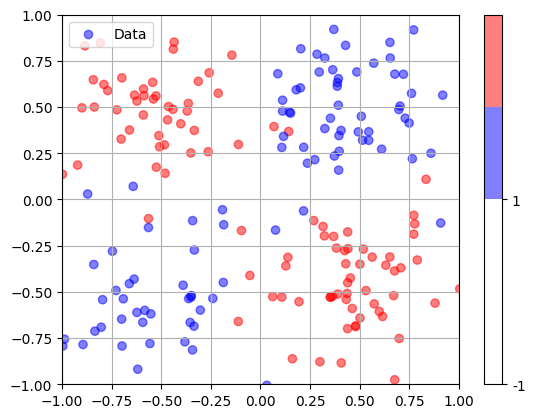

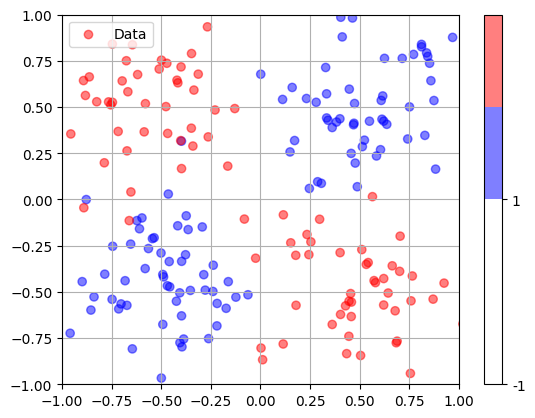

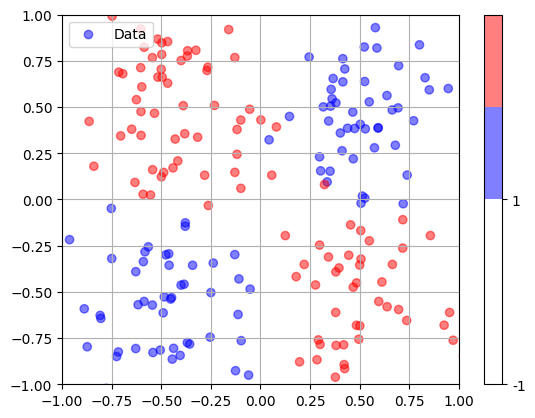

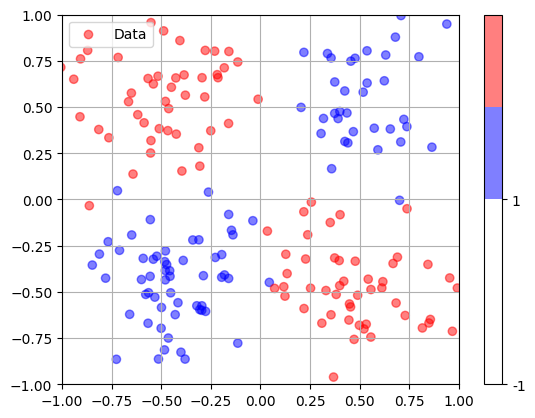

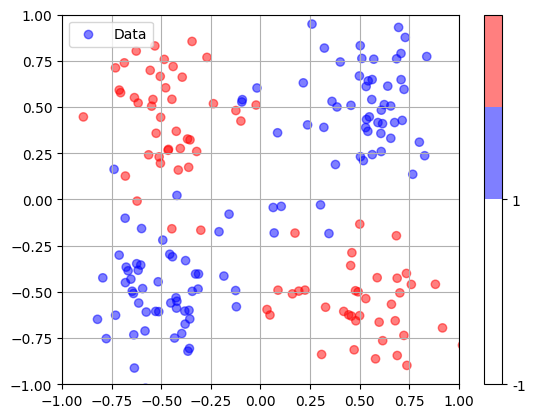

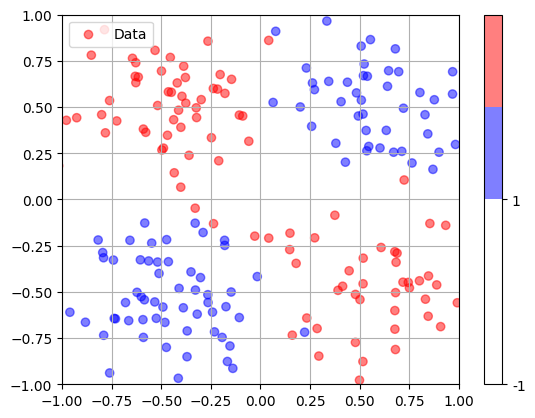

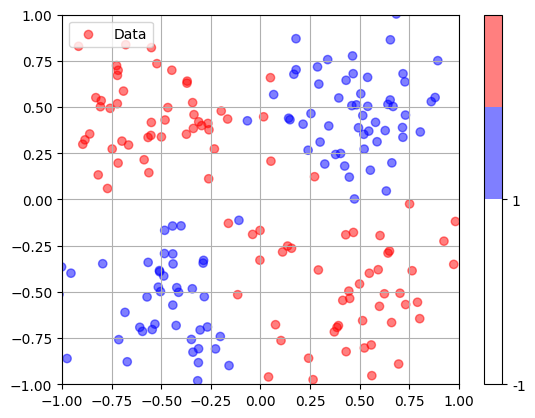

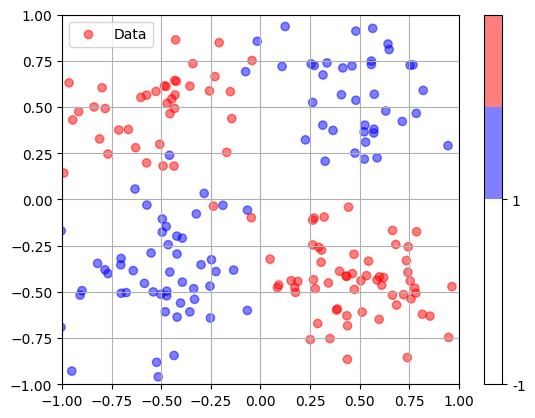

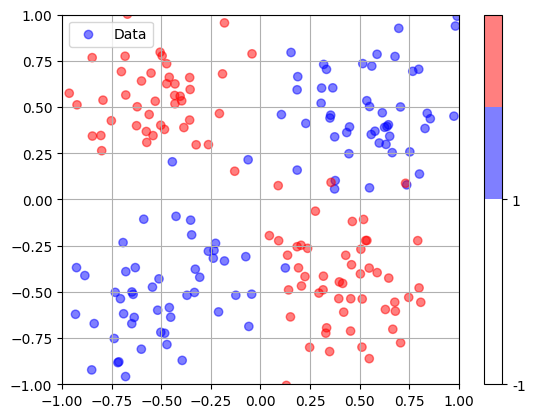

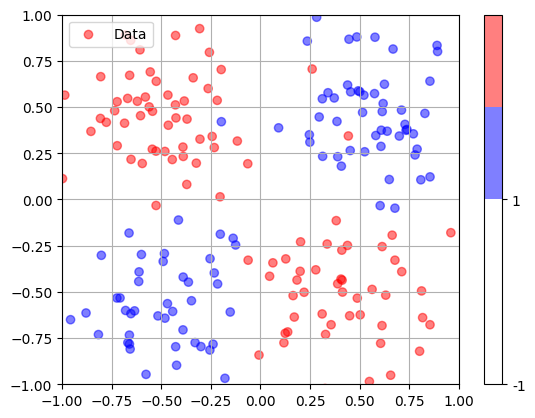

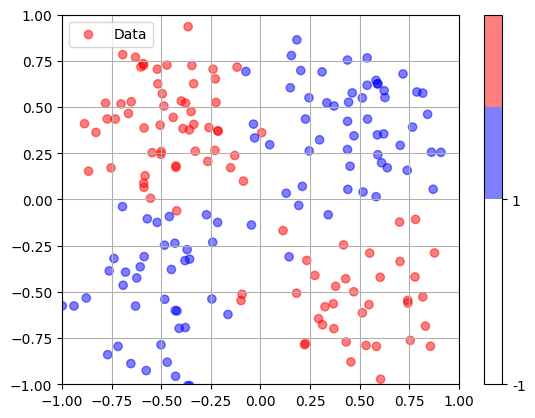

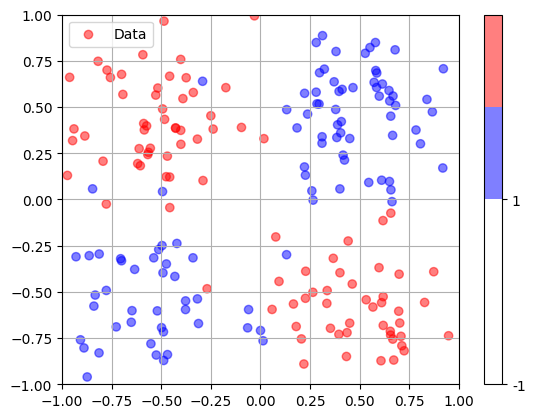

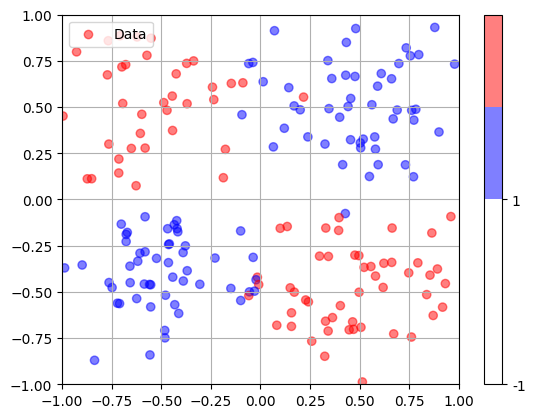

In [ ]:
accuracy_rbf_results = []
seeds = np.linspace(1, 100, 100, dtype=int)
best_accuracy_results = []
best_t_results = []
best_accuracy_2_results = []
best_M_results = []
for seed in seeds:
    # Generate training and testing data
    xTrain3, yTrain3 = generateBatchXor(200, sigma=0.25, seed=seed)
    xTest3, yTest3 = generateBatchXor(50, sigma=0.25, seed=seed)

    # Train and test SVM with custom RBF kernel
    svm_pre = svm.SVC(kernel=custom_rbf_kernel)
    svm_pre.fit(xTrain3, yTrain3)
    predictions = svm_pre.predict(xTest3)
    accuracy_rbf = accuracy_score(yTest3, predictions)
    accuracy_rbf_results.append(accuracy_rbf)

    # Store support vectors and dual coefficients
    support_indices = svm_pre.support_
    support_vectors = xTrain3[support_indices]
    dual = svm_pre.dual_coef_[0]

    # Evaluate SVM with different t values
    best_t = 1
    best_accuracy = 0
    for t in t_values:
        modify = kernel_factory(t)
        svm1 = svm.SVC(kernel=modify)
        svm1.fit(xTrain3, yTrain3)
        predictions5 = svm1.predict(xTest3)
        accuracy = accuracy_score(yTest3, predictions5)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_t = t
    best_accuracy_results.append(best_accuracy)
    best_t_results.append(best_t)

    # Evaluate SVM with different M values for D2 kernel
    best_M = 0
    best_accuracy_2 = 0
    for M in range(len(support_vectors)):
        if M == 0 or M == 1 or M == 2:
            continue
        tau_i_list = []
        for xi in support_vectors:
            distances = np.linalg.norm(support_vectors - xi, axis=1) ** 2
            sorted_indices = np.argsort(distances)
            nearest_indices = sorted_indices[1:M+1]
            nearest_support_vectors = support_vectors[nearest_indices]
            tau_i_sum = np.sum(distances[nearest_indices])
            tau_i = tau_i_sum / M
            tau_i_list.append(tau_i)

        tau_i_list = np.array(tau_i_list)
        modify = kernel_factory_D2(tau_i_list)
        svm2 = svm.SVC(kernel=modify)
        svm2.fit(xTrain3, yTrain3)
        predictions5 = svm2.predict(xTest3)
        accuracy = accuracy_score(yTest3, predictions5)
        if accuracy > best_accuracy_2:
            best_accuracy_2 = accuracy
            best_M = M
    best_accuracy_2_results.append(best_accuracy_2)
    best_M_results.append(best_M)

# Create a DataFrame to store the results


Best Model
modified 1999                                 45
modified 1999 / modified 2002                 24
unmodified / modified 1999 / modified 2002    16
modified 2002                                  8
unmodified / modified 1999                     3
unmodified                                     2
unmodified / modified 2002                     2
Name: count, dtype: int64


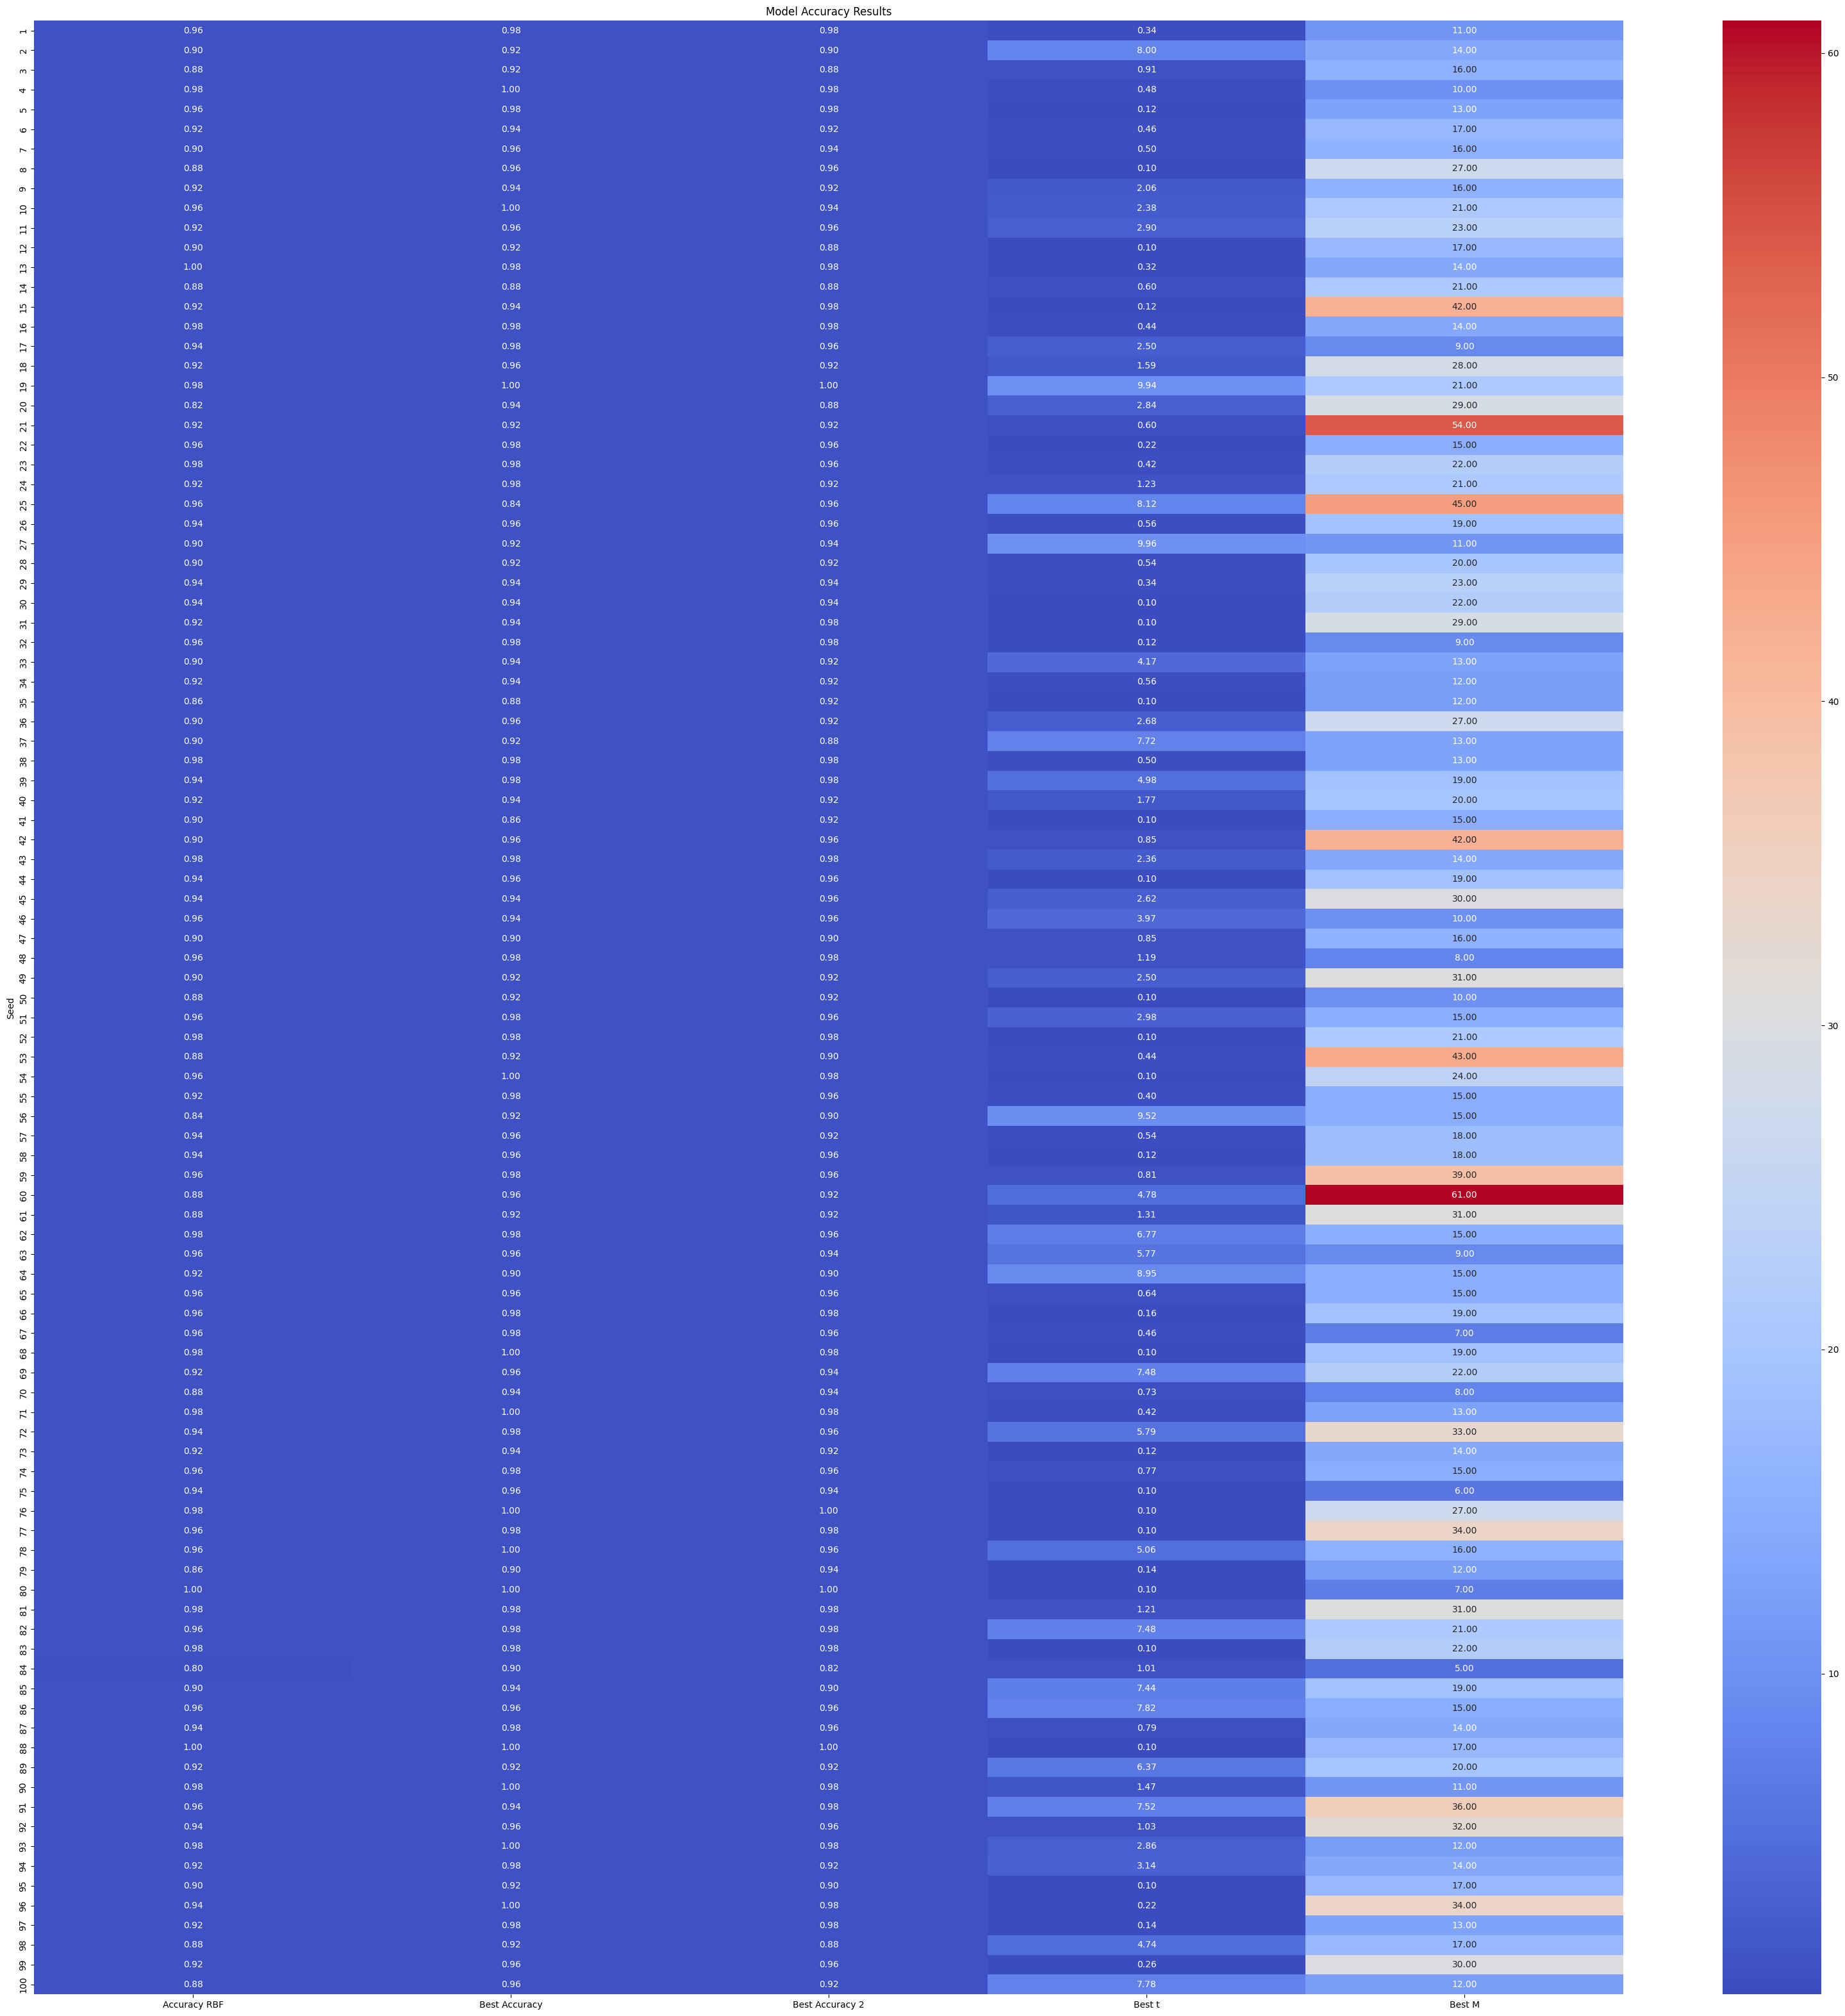

In [ ]:
import pandas as pd
results_df = pd.DataFrame({
    'Seed': seeds,
    'Accuracy RBF': accuracy_rbf_results,
    'Best Accuracy': best_accuracy_results,
    'Best Accuracy 2': best_accuracy_2_results,
    'Best t': best_t_results,
    'Best M': best_M_results
})


def determine_best_model(row):
    accuracies = {
        'unmodified': row['Accuracy RBF'],
        'modified 1999': row['Best Accuracy'],
        'modified 2002': row['Best Accuracy 2']
    }

    max_accuracy = max(accuracies.values())
    best_models = [model for model, accuracy in accuracies.items() if accuracy == max_accuracy]

    if len(best_models) == 1:
        return best_models[0]
    else:
        return ' / '.join(best_models)


results_df['Best Model'] = results_df.apply(determine_best_model, axis=1)

# Count the number of times each model has the best accuracy
best_model_counts = results_df['Best Model'].value_counts()

# Print the count of best models
print(best_model_counts)

# Plot the results in a matrix format
fig, ax = plt.subplots(figsize=(40, 40))
sns.heatmap(results_df.set_index('Seed').drop(columns='Best Model'), annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
plt.title('Model Accuracy Results')
plt.show()

In [ ]:
seed = 96
xTrain3, yTrain3 = generateBatchXor(200, sigma=0.25, seed=seed)
xTest3, yTest3 = generateBatchXor(50, sigma=0.25, seed=seed)

# Train and test SVM with custom RBF kernel
svm_pre = svm.SVC(kernel=custom_rbf_kernel)
svm_pre.fit(xTrain3, yTrain3)
predictions = svm_pre.predict(xTest3)
accuracy_rbf = accuracy_score(yTest3, predictions)
precision_rbf = precision_score(yTest3, predictions)
recall_rbf = recall_score(yTest3, predictions)
f1_rbf = f1_score(yTest3, predictions)

print(f"Unmodified Kernel: Accuracy={accuracy_rbf}, Precision={precision_rbf}, Recall={recall_rbf}, F1={f1_rbf}")

# Store support vectors and dual coefficients
support_indices = svm_pre.support_
support_vectors = xTrain3[support_indices]
dual = svm_pre.dual_coef_[0]

# Evaluate SVM with different t values
best_t = 1
best_accuracy = 0
for t in t_values:
    modify = kernel_factory(t)
    svm1 = svm.SVC(kernel=modify)
    svm1.fit(xTrain3, yTrain3)
    predictions5 = svm1.predict(xTest3)
    accuracy = accuracy_score(yTest3, predictions5)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_t = t

precision_t = precision_score(yTest3, predictions5)
recall_t = recall_score(yTest3, predictions5)
f1_t = f1_score(yTest3, predictions5)

print(f"Modified Kernel 1999: Accuracy={best_accuracy}, Precision={precision_t}, Recall={recall_t}, F1={f1_t}")

# Evaluate SVM with different M values for D2 kernel
best_M = 0
best_accuracy_2 = 0
for M in range(len(support_vectors)):
    if M == 0 or M == 1 or M == 2:
        continue
    tau_i_list = []
    for xi in support_vectors:
        distances = np.linalg.norm(support_vectors - xi, axis=1) ** 2
        sorted_indices = np.argsort(distances)
        nearest_indices = sorted_indices[1:M+1]
        nearest_support_vectors = support_vectors[nearest_indices]
        tau_i_sum = np.sum(distances[nearest_indices])
        tau_i = tau_i_sum / M
        tau_i_list.append(tau_i)

    tau_i_list = np.array(tau_i_list)
    modify = kernel_factory_D2(tau_i_list)
    svm2 = svm.SVC(kernel=modify)
    svm2.fit(xTrain3, yTrain3)
    predictions5 = svm2.predict(xTest3)
    accuracy = accuracy_score(yTest3, predictions5)
    if accuracy > best_accuracy_2:
        best_accuracy_2 = accuracy
        best_M = M

precision_M = precision_score(yTest3, predictions5)
recall_M = recall_score(yTest3, predictions5)
f1_M = f1_score(yTest3, predictions5)

print(f"Modified Kernel 2002: Accuracy={best_accuracy_2}, Precision={precision_M}, Recall={recall_M}, F1={f1_M}")

Unmodified Kernel: Accuracy=0.94, Precision=0.967741935483871, Recall=0.9375, F1=0.9523809523809523
Modified Kernel 1999: Accuracy=1.0, Precision=0.96875, Recall=0.96875, F1=0.96875
Modified Kernel 2002: Accuracy=0.98, Precision=1.0, Recall=0.9375, F1=0.967741935483871
